This is to identify best target profit and stop loss combination for SOSI Final Version, which only provides signal at 9:20 AM everyday and provides accurate update on whether the trade should be taken or not.

This contains all sosi values and all plots used for calculating the buy signals.

Processing NSE_NIFTY240620C23400, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620C23400, 1.csv. Skipping...
Processing NSE_NIFTY240620C23500, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620C23500, 1.csv. Skipping...
Processing NSE_NIFTY240620C23550, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620C23550, 1.csv. Skipping...
Processing NSE_NIFTY240620C23600, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620C23600, 1.csv. Skipping...
Processing NSE_NIFTY240620P23400, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620P23400, 1.csv. Skipping...
Processing NSE_NIFTY240620P23500, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620P23500, 1.csv. Skipping...
Processing NSE_NIFTY240620P23550, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620P23550, 1.csv. Skipping...
Processing NSE_NIFTY240620P23600, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620P23600, 1.csv. Skipping...
Processing NSE_NIFTY240627C23300, 1.csv in NIFTY

C:\temp\ipykernel_1552\86755851.py:308: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_trade_results = pd.concat(trade_results_combined, ignore_index=True)
C:\temp\ipykernel_1552\86755851.py:309: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_all_results = pd.concat(all_combined_results, ignore_index=True)


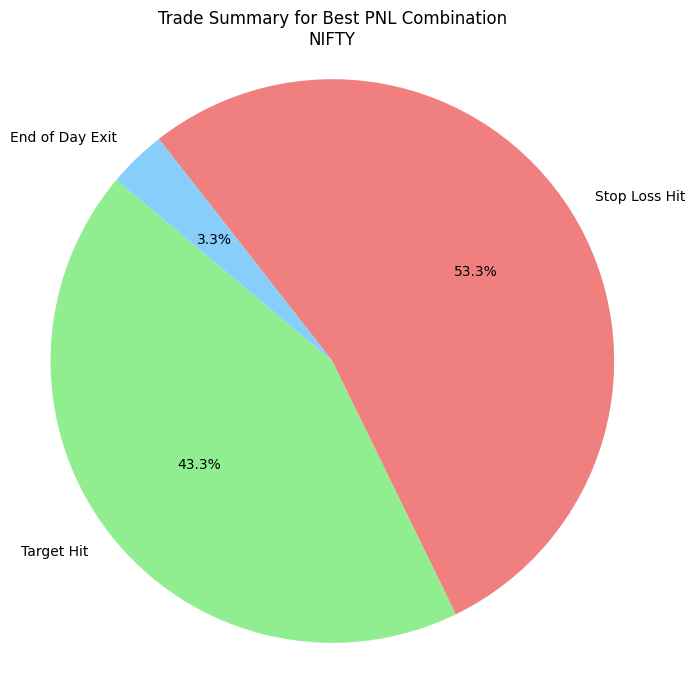

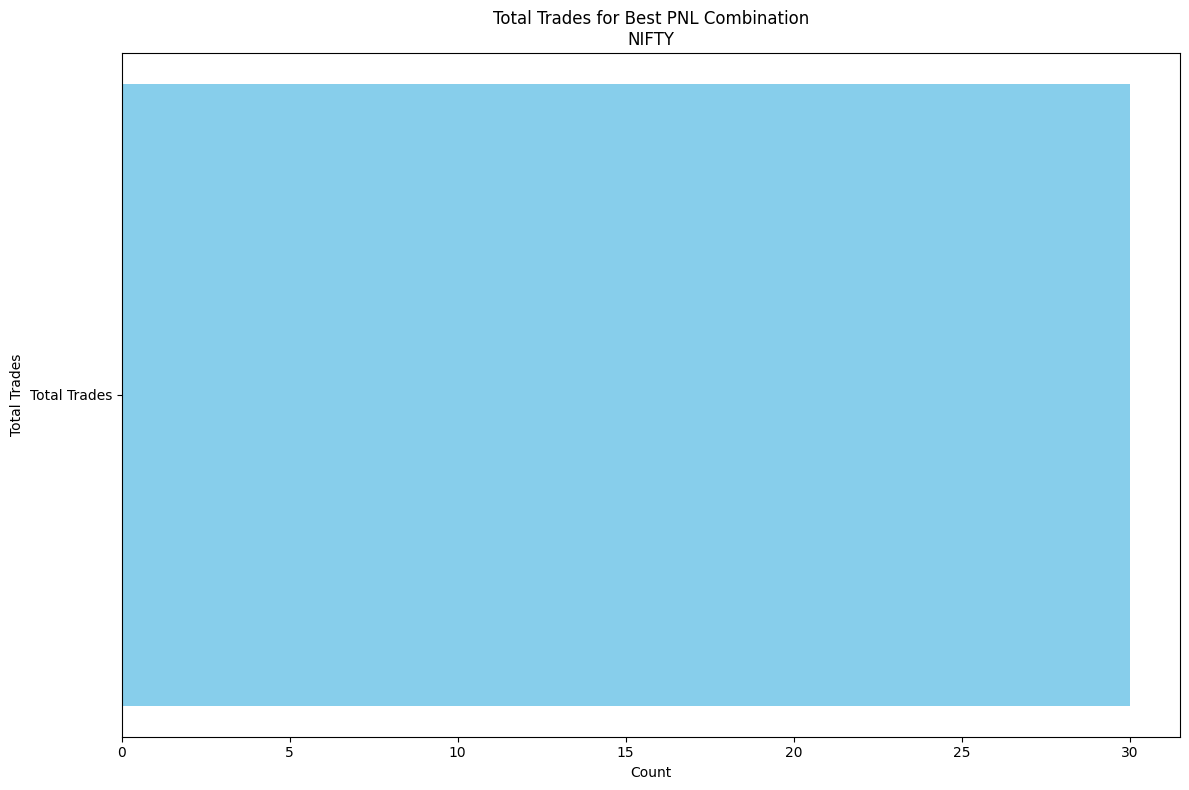

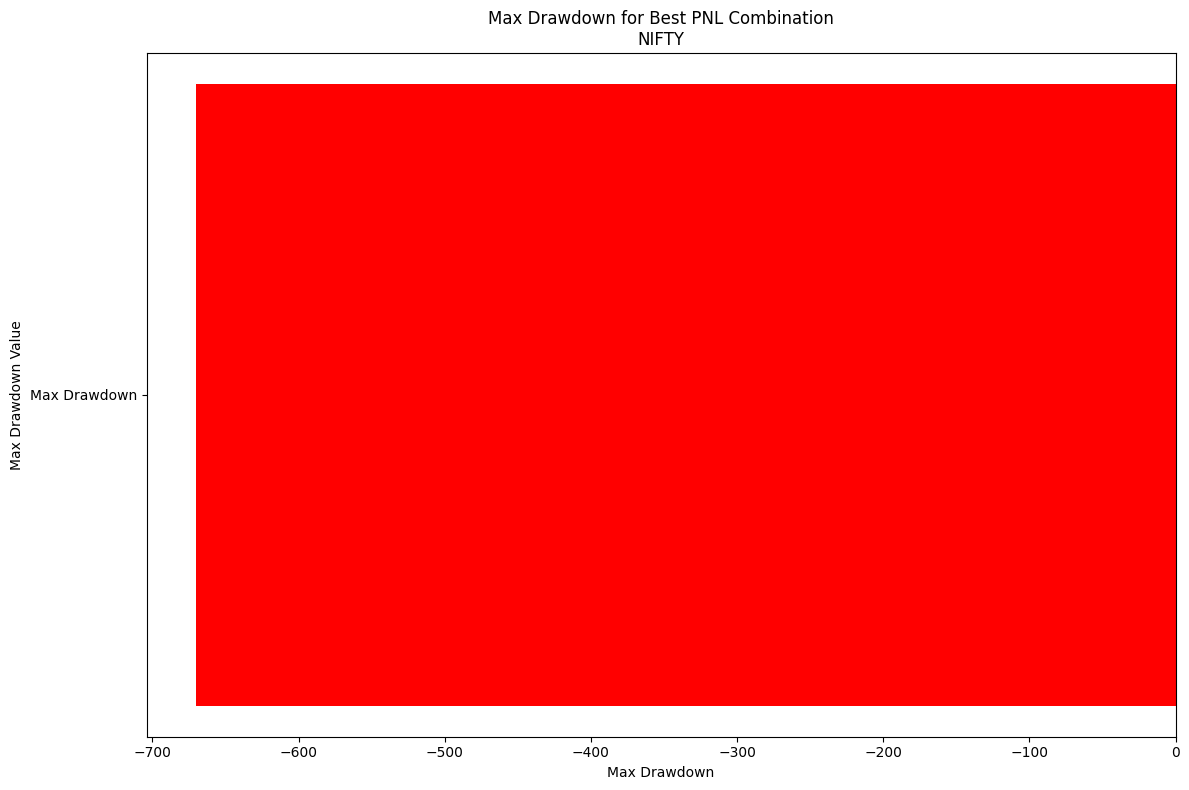

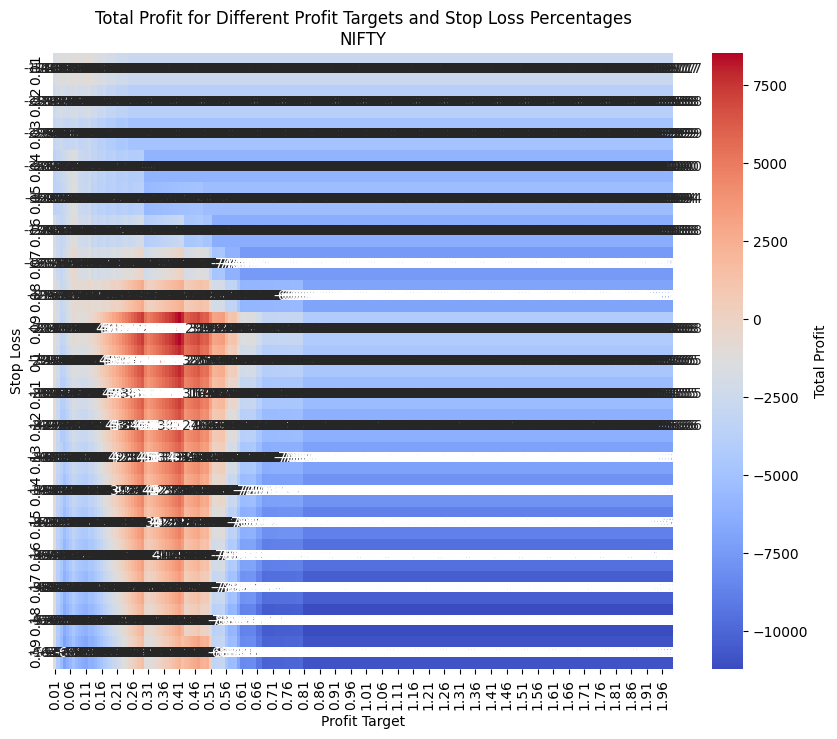

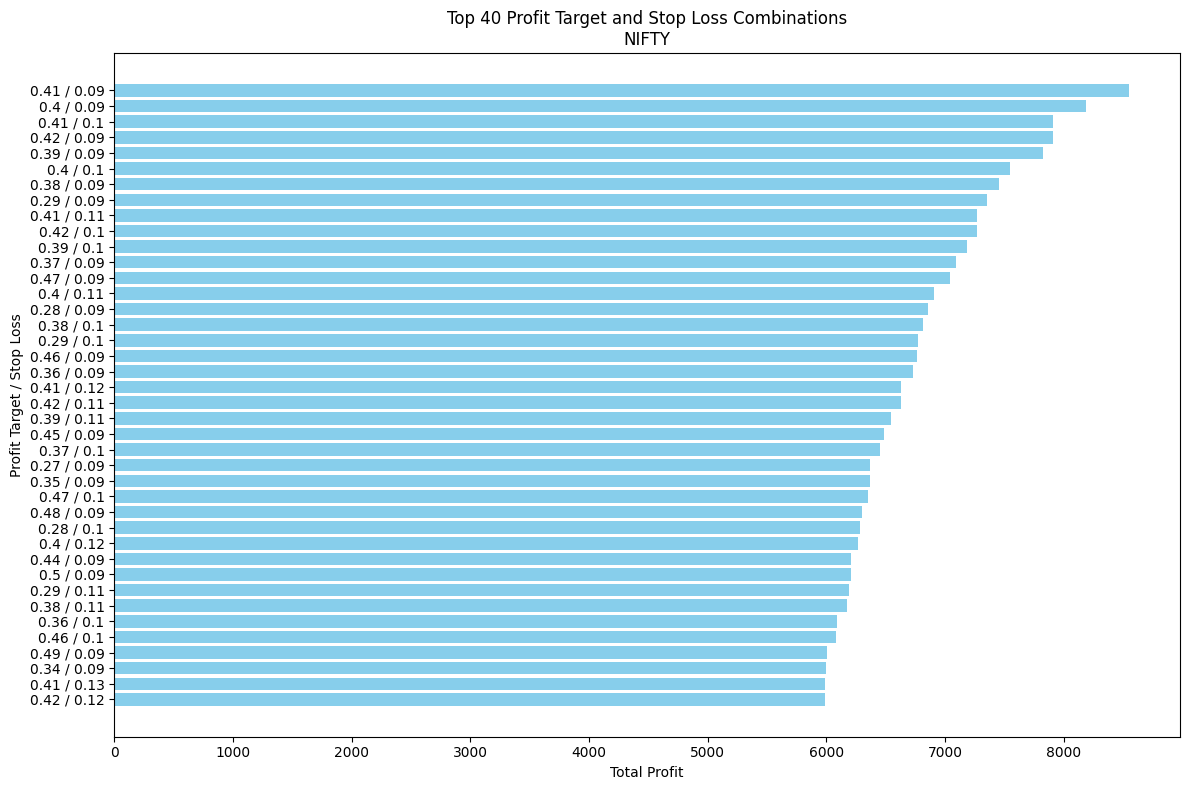

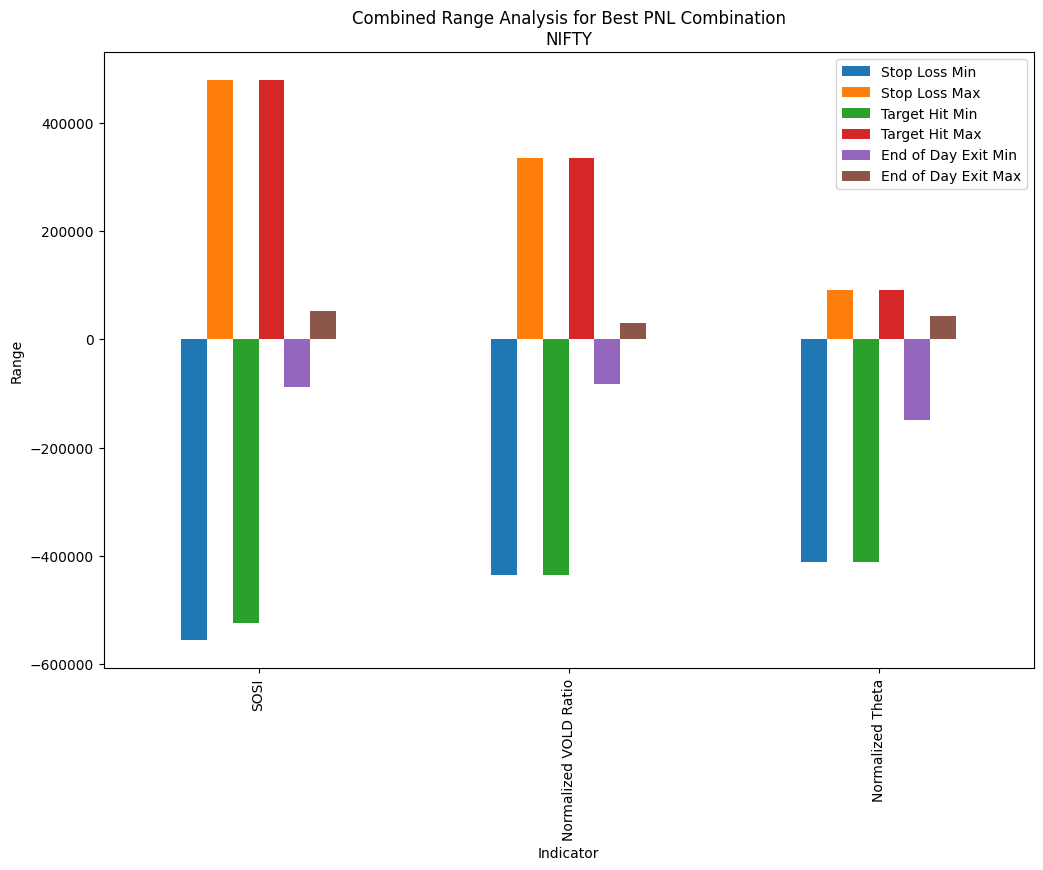

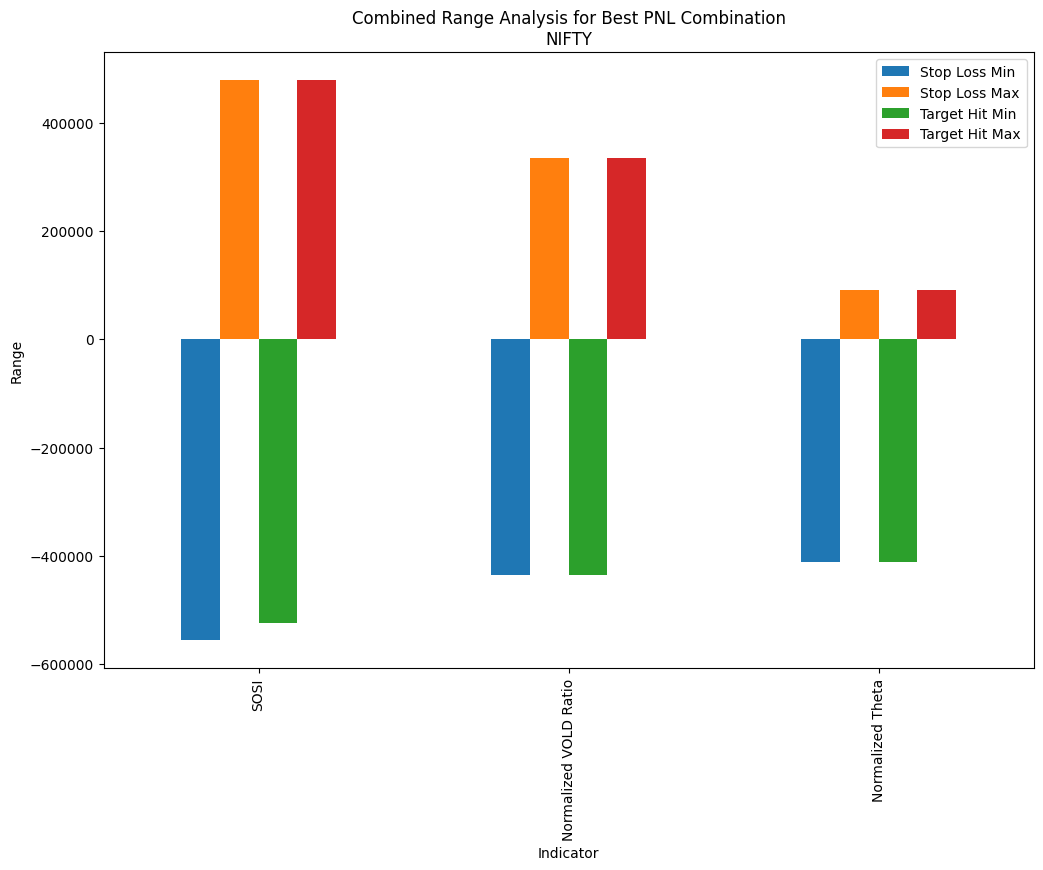

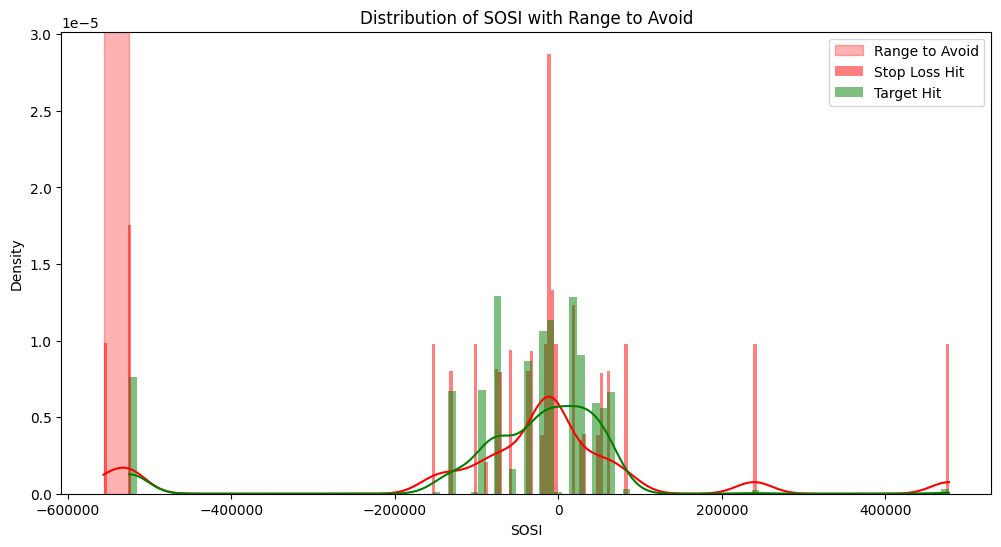

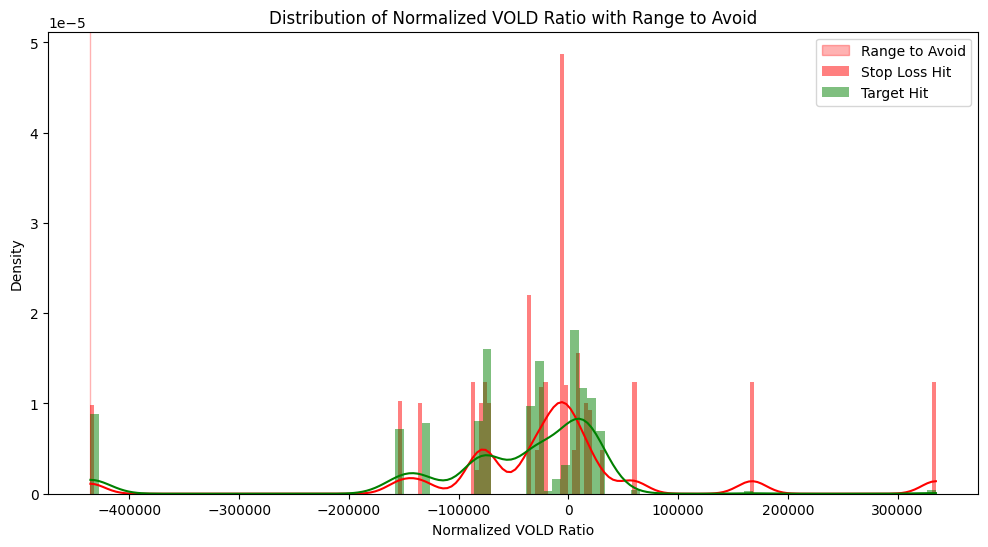

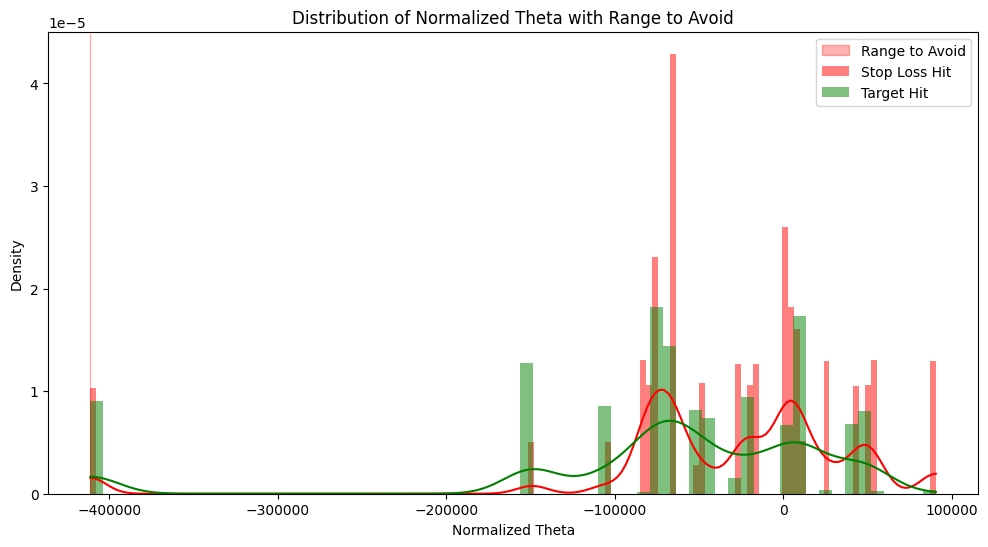

Re-processing NSE_NIFTY240620C23400, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620C23400, 1.csv. Skipping...
Re-processing NSE_NIFTY240620C23500, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620C23500, 1.csv. Skipping...
Re-processing NSE_NIFTY240620C23550, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620C23550, 1.csv. Skipping...
Re-processing NSE_NIFTY240620C23600, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620C23600, 1.csv. Skipping...
Re-processing NSE_NIFTY240620P23400, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620P23400, 1.csv. Skipping...
Re-processing NSE_NIFTY240620P23500, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620P23500, 1.csv. Skipping...
Re-processing NSE_NIFTY240620P23550, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620P23550, 1.csv. Skipping...
Re-processing NSE_NIFTY240620P23600, 1.csv in NIFTY...
No buy signals found for NSE_NIFTY240620P23600, 1.csv. Skipping...
Re-processing NSE_NIFTY2

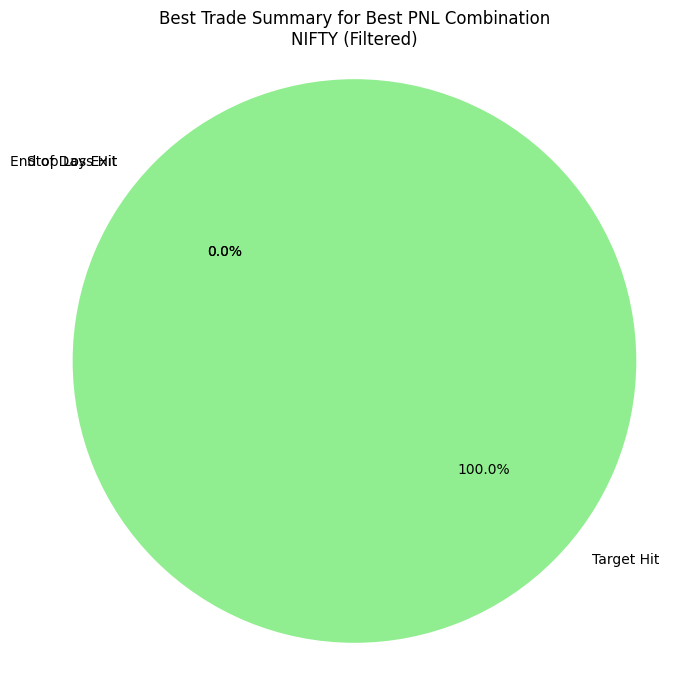

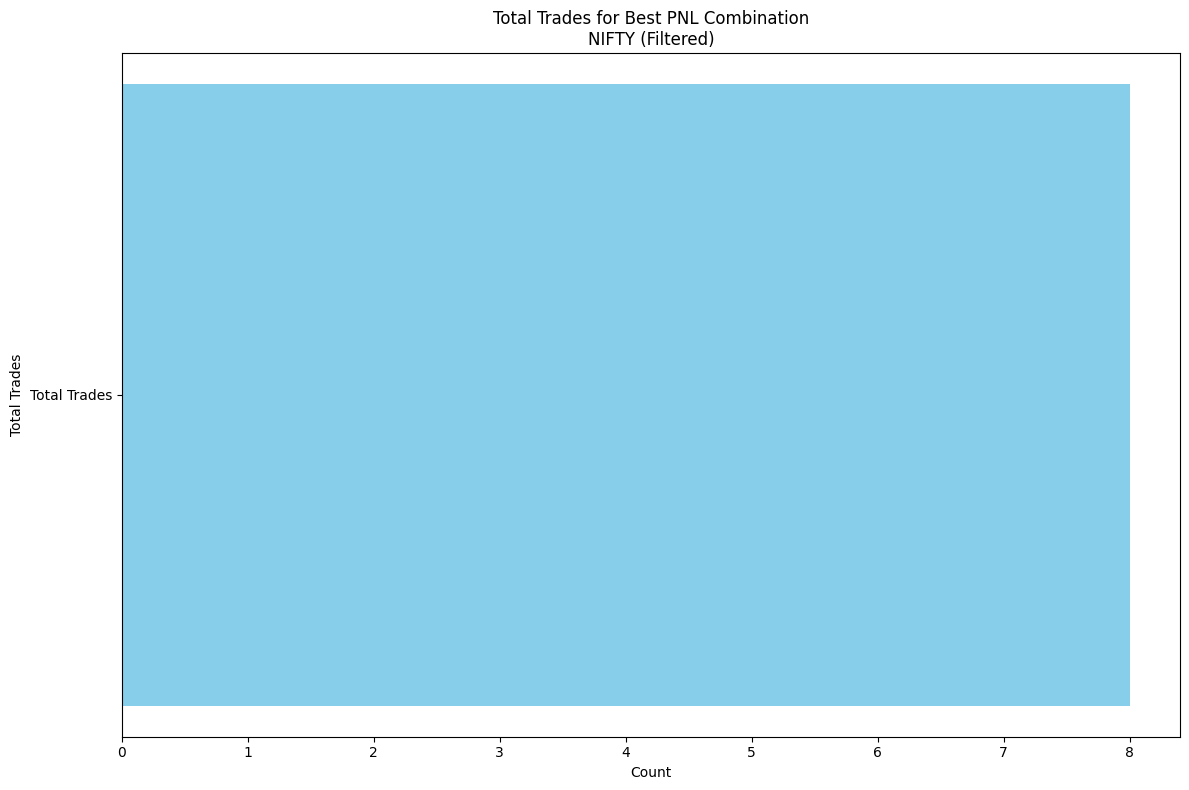

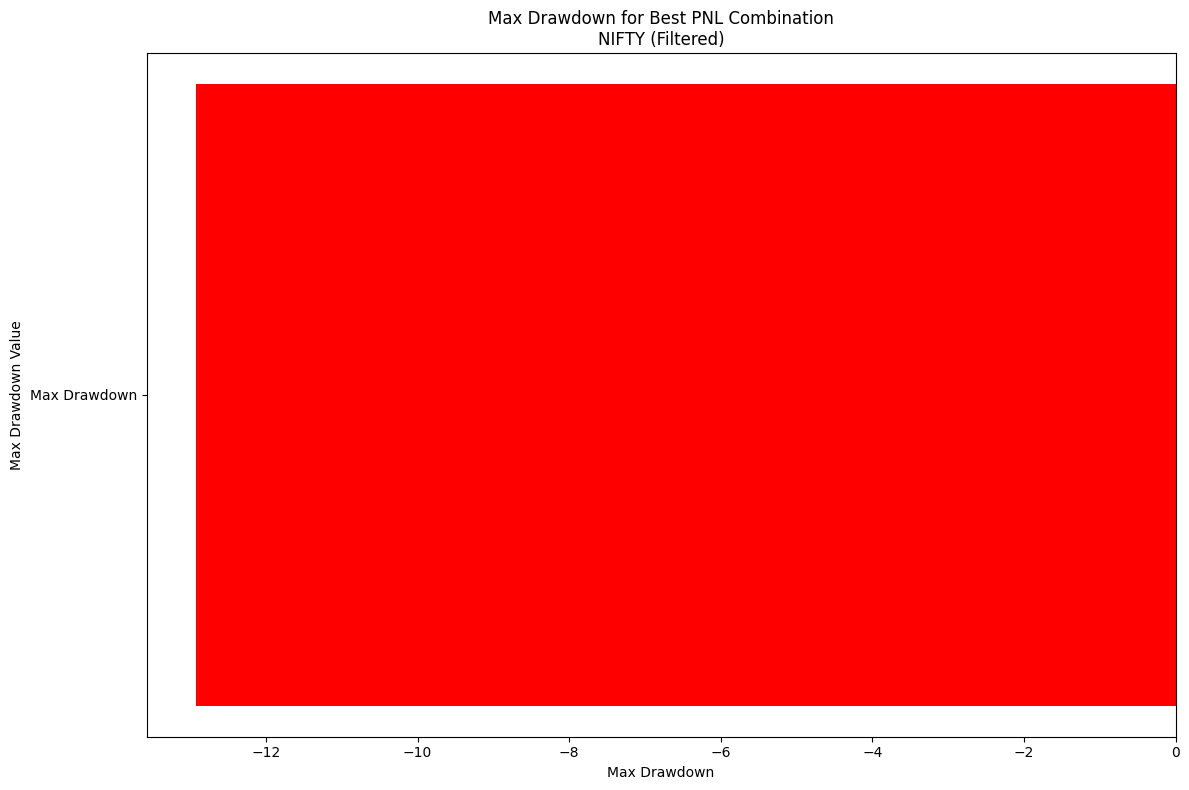

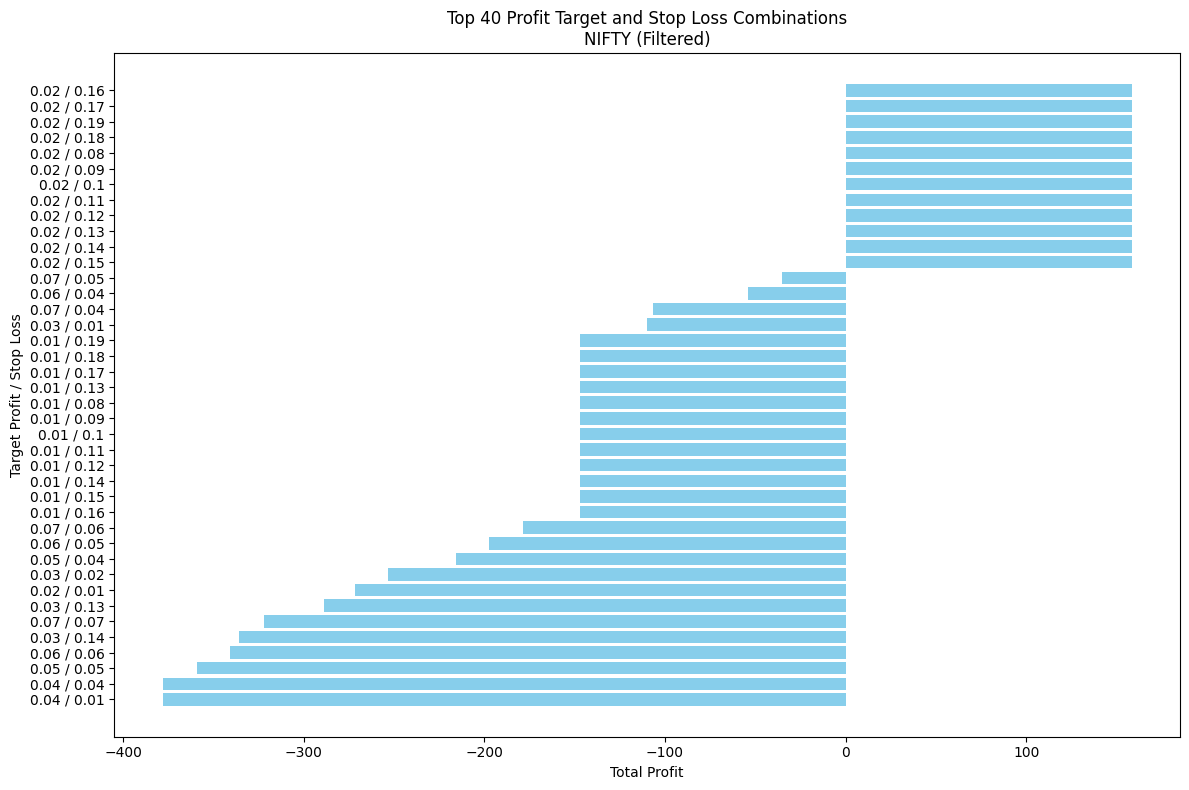

Processing NSE_BANKNIFTY240619C50400, 1.csv in BANKNIFTY...
No buy signals found for NSE_BANKNIFTY240619C50400, 1.csv. Skipping...
Processing NSE_BANKNIFTY240619C50500, 1.csv in BANKNIFTY...
No buy signals found for NSE_BANKNIFTY240619C50500, 1.csv. Skipping...
Processing NSE_BANKNIFTY240619C50600, 1.csv in BANKNIFTY...
No buy signals found for NSE_BANKNIFTY240619C50600, 1.csv. Skipping...
Processing NSE_BANKNIFTY240619P50400, 1.csv in BANKNIFTY...
No buy signals found for NSE_BANKNIFTY240619P50400, 1.csv. Skipping...
Processing NSE_BANKNIFTY240619P50500, 1.csv in BANKNIFTY...
No buy signals found for NSE_BANKNIFTY240619P50500, 1.csv. Skipping...
Processing NSE_BANKNIFTY240619P50600, 1.csv in BANKNIFTY...
No buy signals found for NSE_BANKNIFTY240619P50600, 1.csv. Skipping...
Processing NSE_BANKNIFTY240626C51300, 1.csv in BANKNIFTY...
No buy signals found for NSE_BANKNIFTY240626C51300, 1.csv. Skipping...
Processing NSE_BANKNIFTY240626C51400, 1.csv in BANKNIFTY...
No buy signals found fo

C:\temp\ipykernel_1552\86755851.py:308: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_trade_results = pd.concat(trade_results_combined, ignore_index=True)
C:\temp\ipykernel_1552\86755851.py:309: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_all_results = pd.concat(all_combined_results, ignore_index=True)


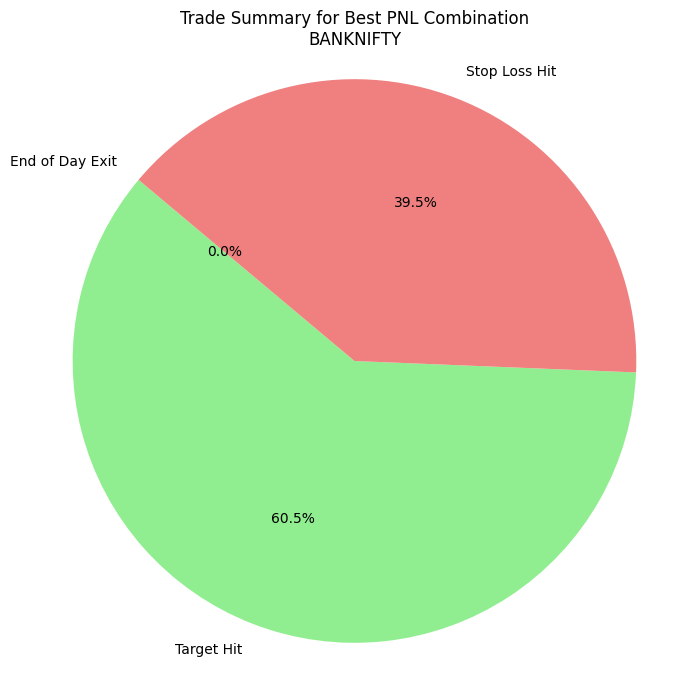

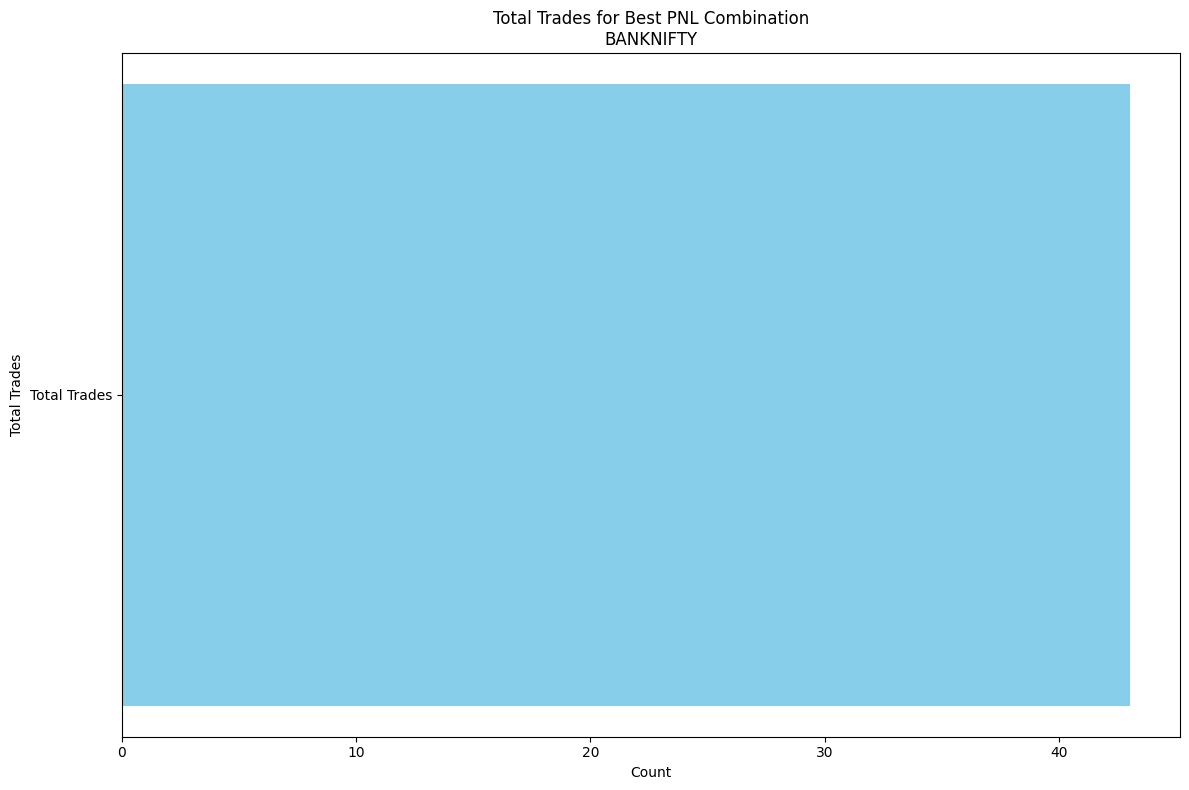

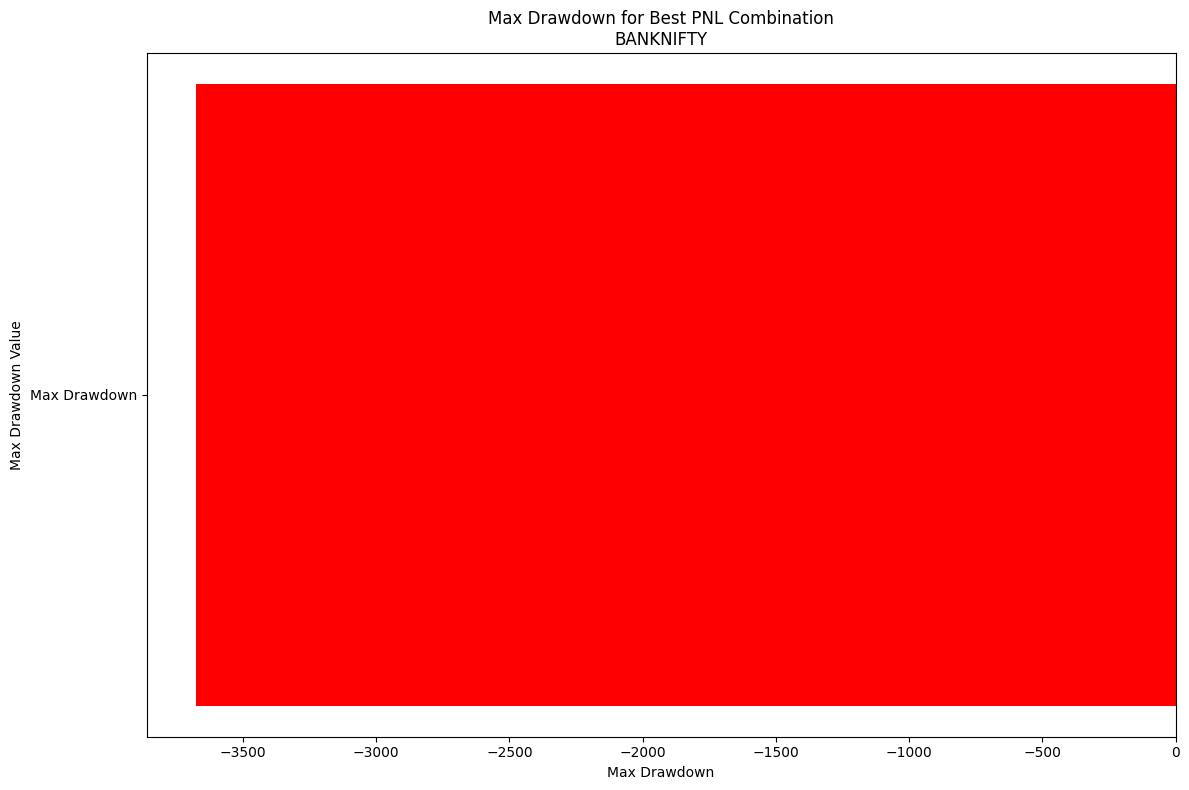

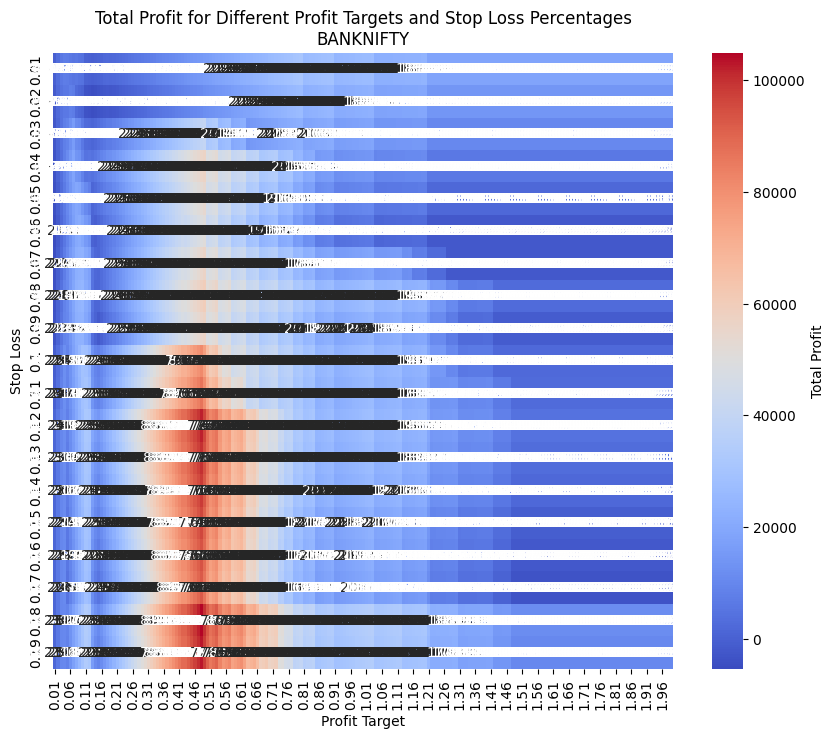

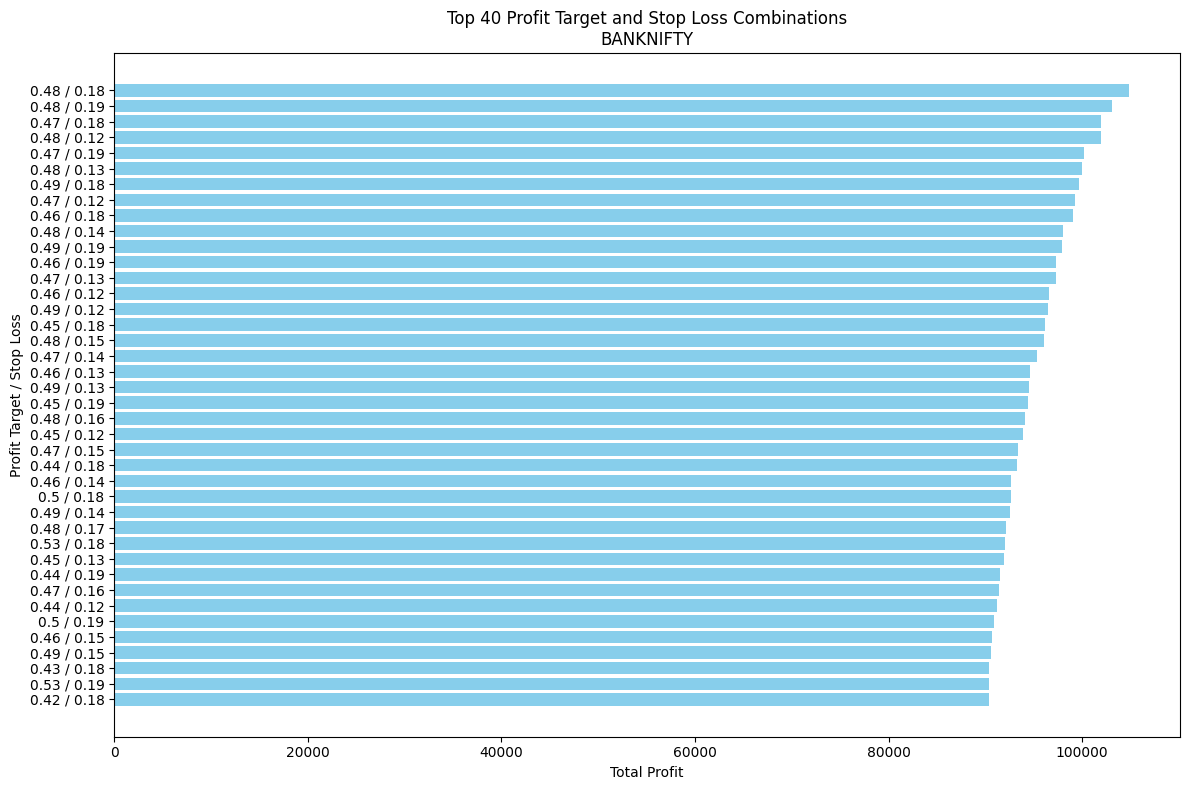

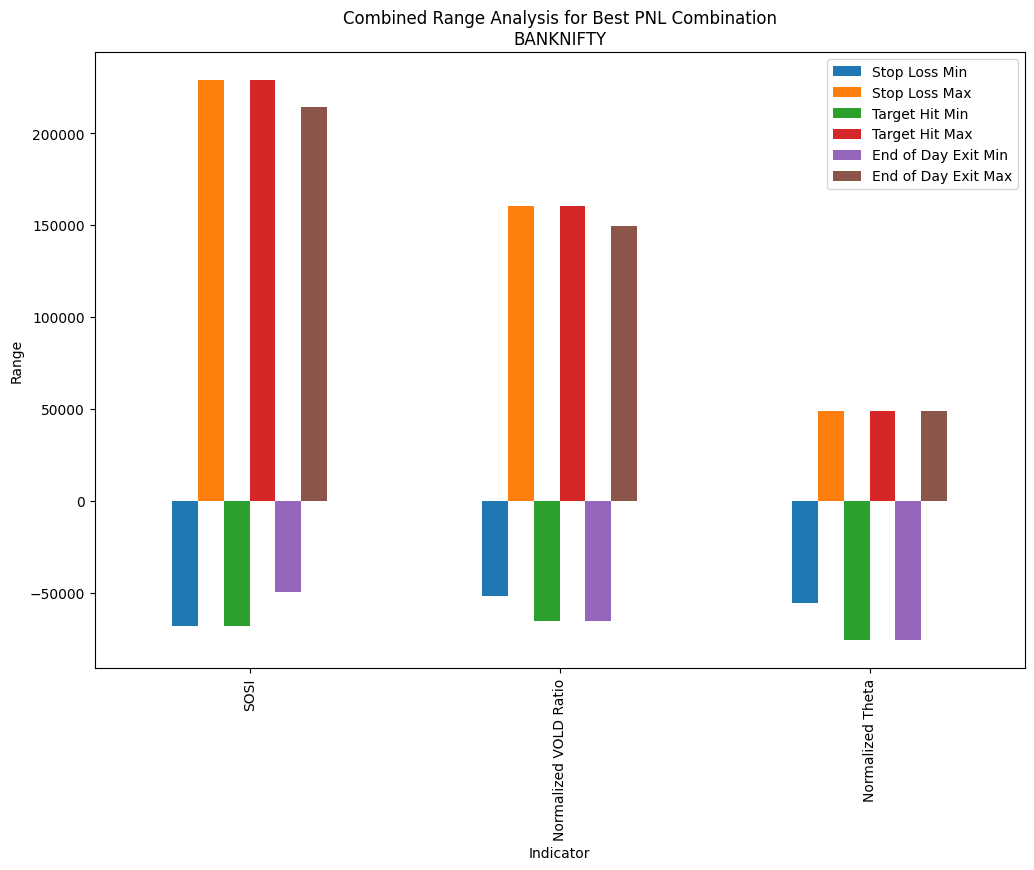

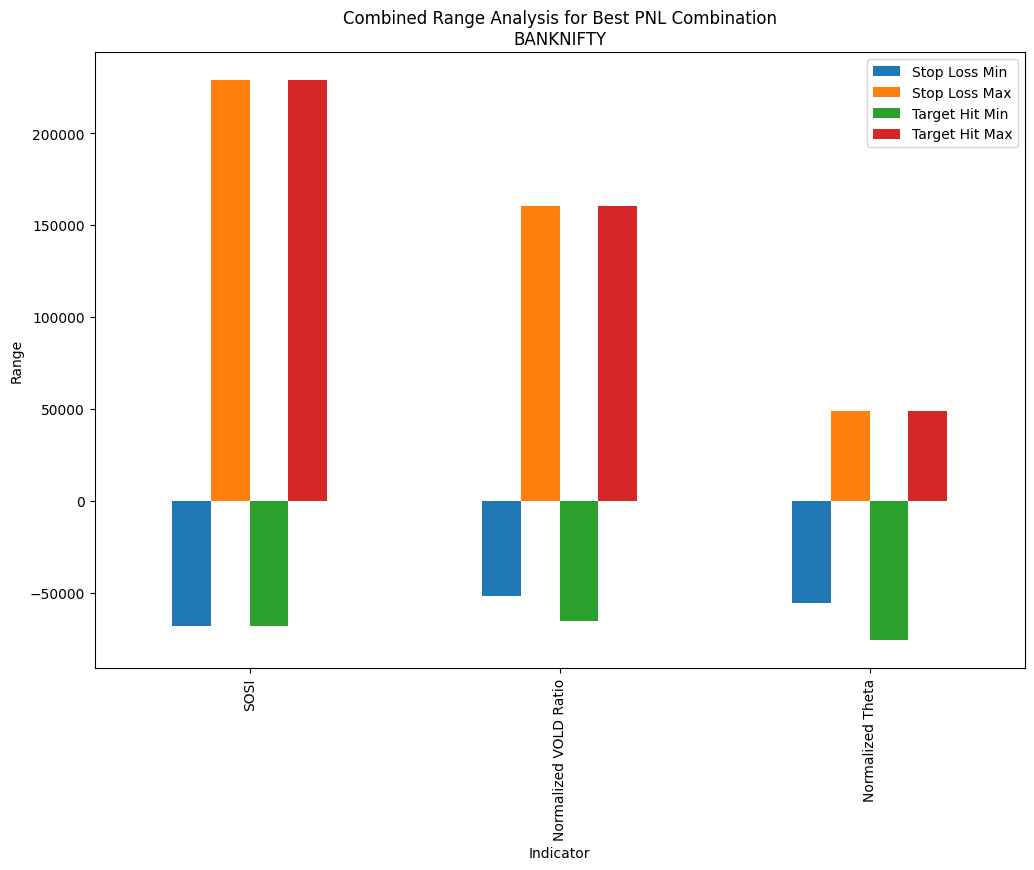

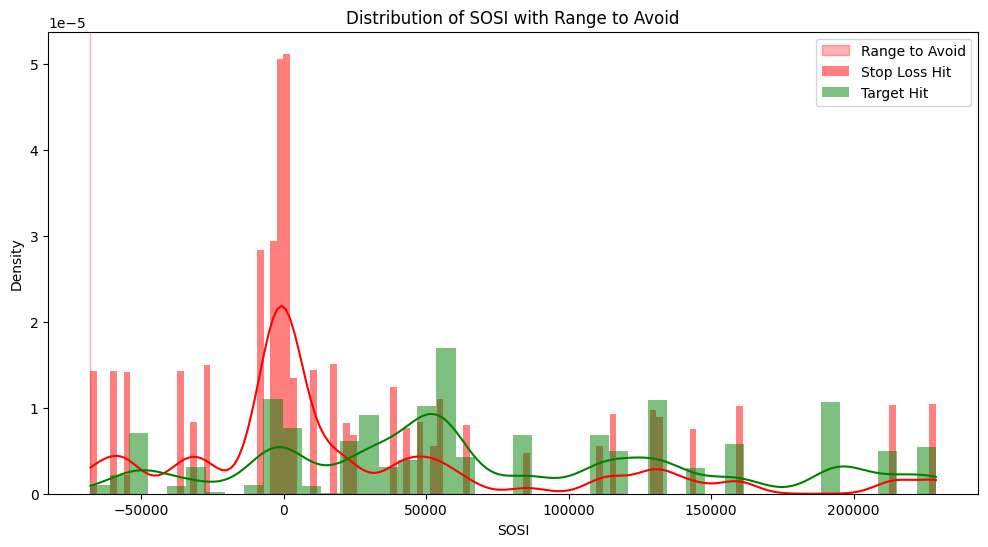

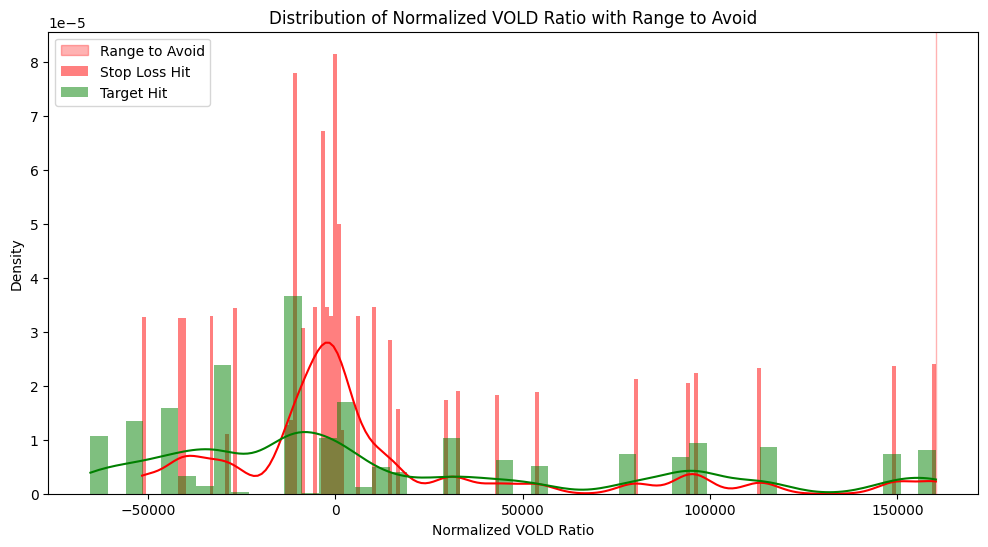

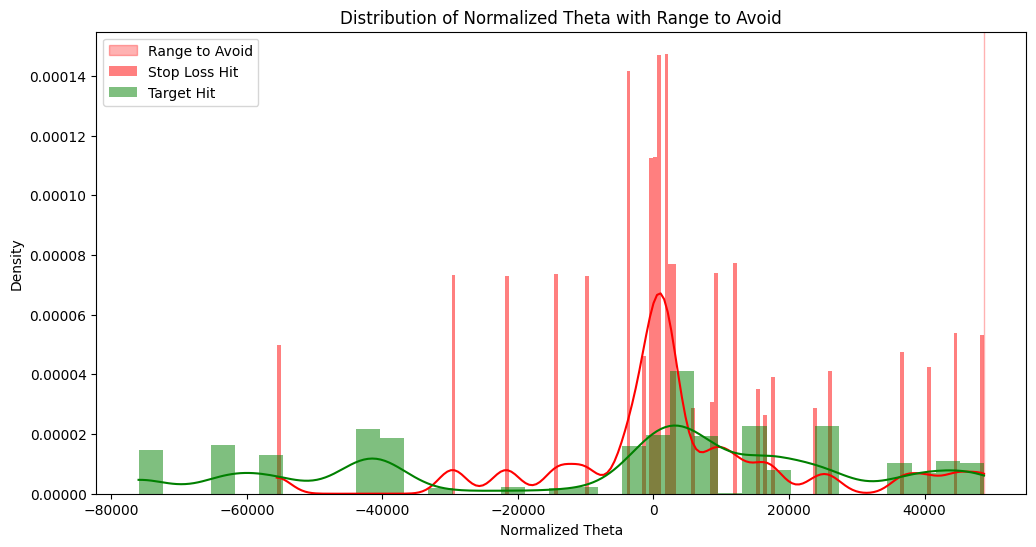

Re-processing NSE_BANKNIFTY240619C50400, 1.csv in BANKNIFTY...
No buy signals found for NSE_BANKNIFTY240619C50400, 1.csv. Skipping...
Re-processing NSE_BANKNIFTY240619C50500, 1.csv in BANKNIFTY...
No buy signals found for NSE_BANKNIFTY240619C50500, 1.csv. Skipping...
Re-processing NSE_BANKNIFTY240619C50600, 1.csv in BANKNIFTY...
No buy signals found for NSE_BANKNIFTY240619C50600, 1.csv. Skipping...
Re-processing NSE_BANKNIFTY240619P50400, 1.csv in BANKNIFTY...
No buy signals found for NSE_BANKNIFTY240619P50400, 1.csv. Skipping...
Re-processing NSE_BANKNIFTY240619P50500, 1.csv in BANKNIFTY...
No buy signals found for NSE_BANKNIFTY240619P50500, 1.csv. Skipping...
Re-processing NSE_BANKNIFTY240619P50600, 1.csv in BANKNIFTY...
No buy signals found for NSE_BANKNIFTY240619P50600, 1.csv. Skipping...
Re-processing NSE_BANKNIFTY240626C51300, 1.csv in BANKNIFTY...
No buy signals found for NSE_BANKNIFTY240626C51300, 1.csv. Skipping...
Re-processing NSE_BANKNIFTY240626C51400, 1.csv in BANKNIFTY...

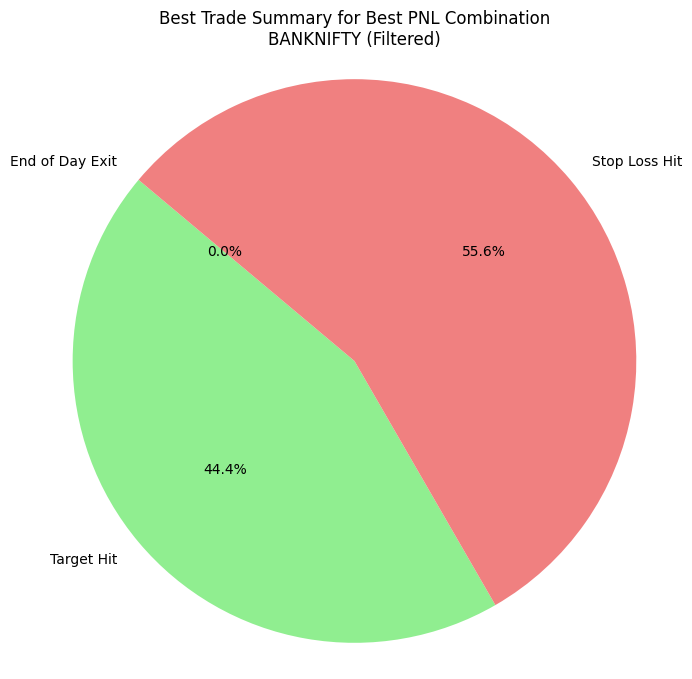

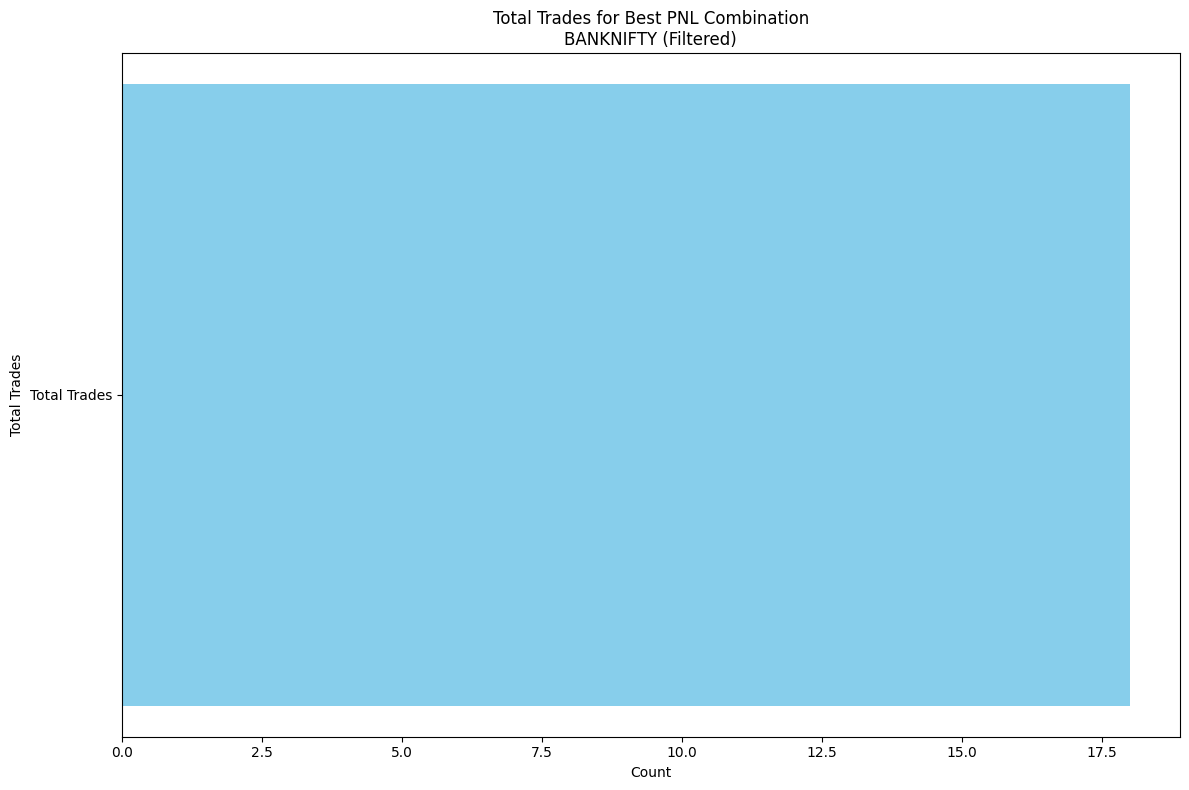

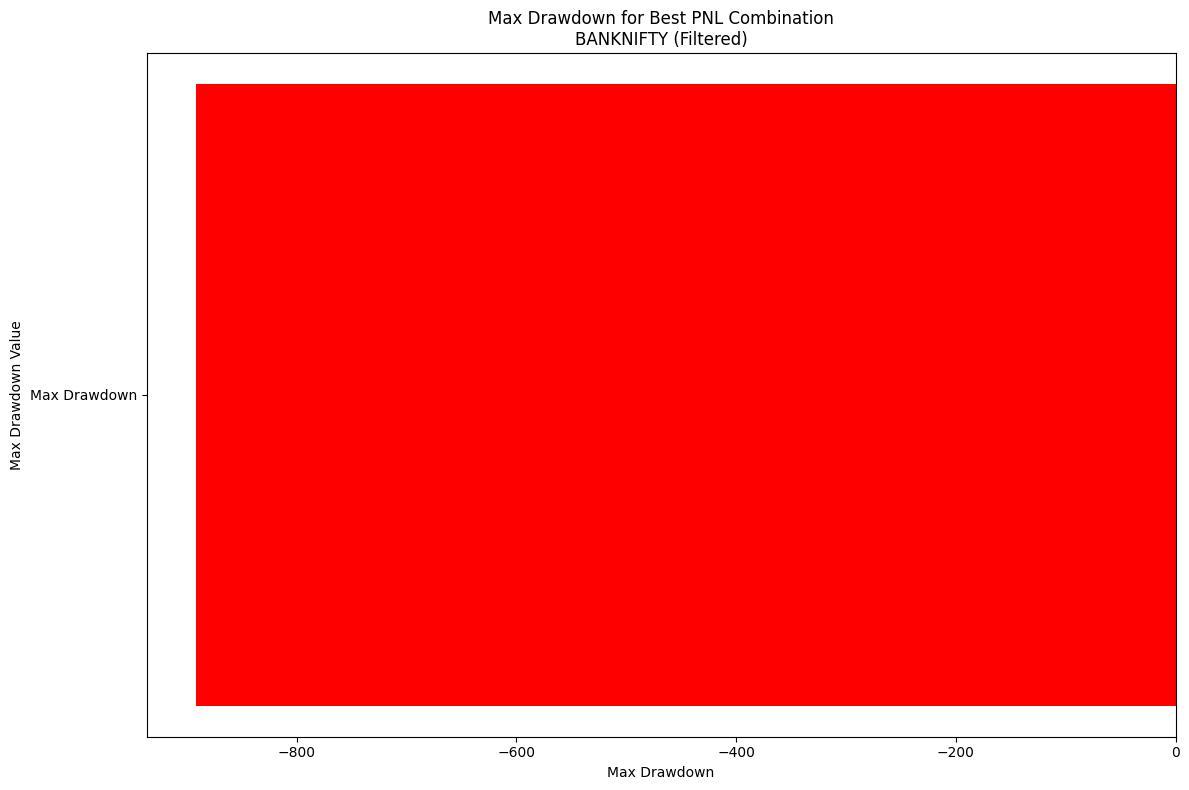

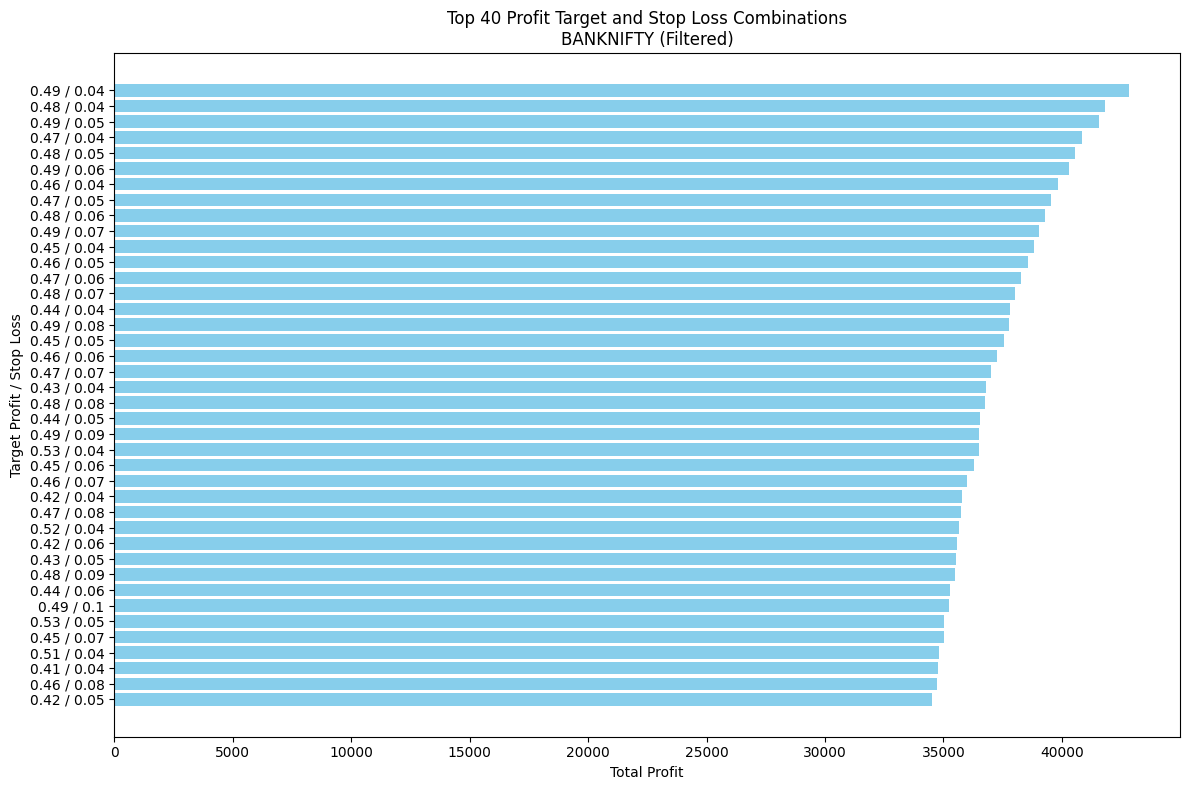

Processing NSE_FINNIFTY240625C22500, 1.csv in FINNIFTY...
No buy signals found for NSE_FINNIFTY240625C22500, 1.csv. Skipping...
Processing NSE_FINNIFTY240625C22800, 1.csv in FINNIFTY...
No buy signals found for NSE_FINNIFTY240625C22800, 1.csv. Skipping...
Processing NSE_FINNIFTY240625C22900, 1.csv in FINNIFTY...
No buy signals found for NSE_FINNIFTY240625C22900, 1.csv. Skipping...
Processing NSE_FINNIFTY240625C23000, 1.csv in FINNIFTY...
No buy signals found for NSE_FINNIFTY240625C23000, 1.csv. Skipping...
Processing NSE_FINNIFTY240625C23100, 1.csv in FINNIFTY...
No buy signals found for NSE_FINNIFTY240625C23100, 1.csv. Skipping...
Processing NSE_FINNIFTY240625C23500, 1.csv in FINNIFTY...
Error: 'volume' column not found in the data.
No buy signals found for NSE_FINNIFTY240625C23500, 1.csv. Skipping...
Processing NSE_FINNIFTY240625P22800, 1.csv in FINNIFTY...
No buy signals found for NSE_FINNIFTY240625P22800, 1.csv. Skipping...
Processing NSE_FINNIFTY240625P22900, 1.csv in FINNIFTY...


C:\temp\ipykernel_1552\86755851.py:308: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_trade_results = pd.concat(trade_results_combined, ignore_index=True)
C:\temp\ipykernel_1552\86755851.py:309: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_all_results = pd.concat(all_combined_results, ignore_index=True)


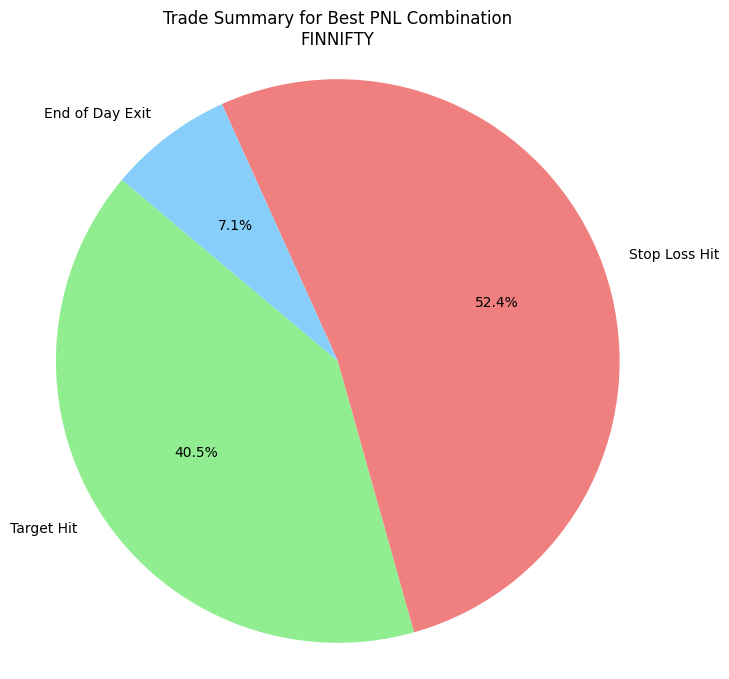

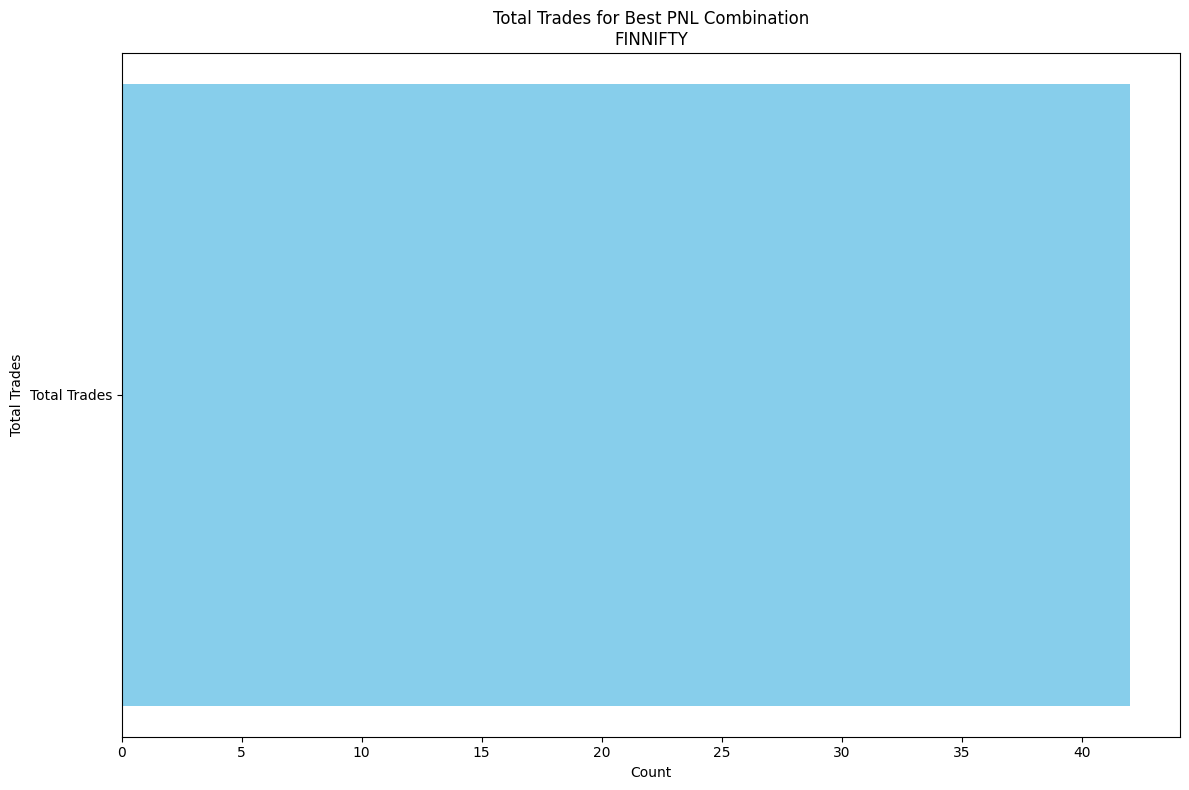

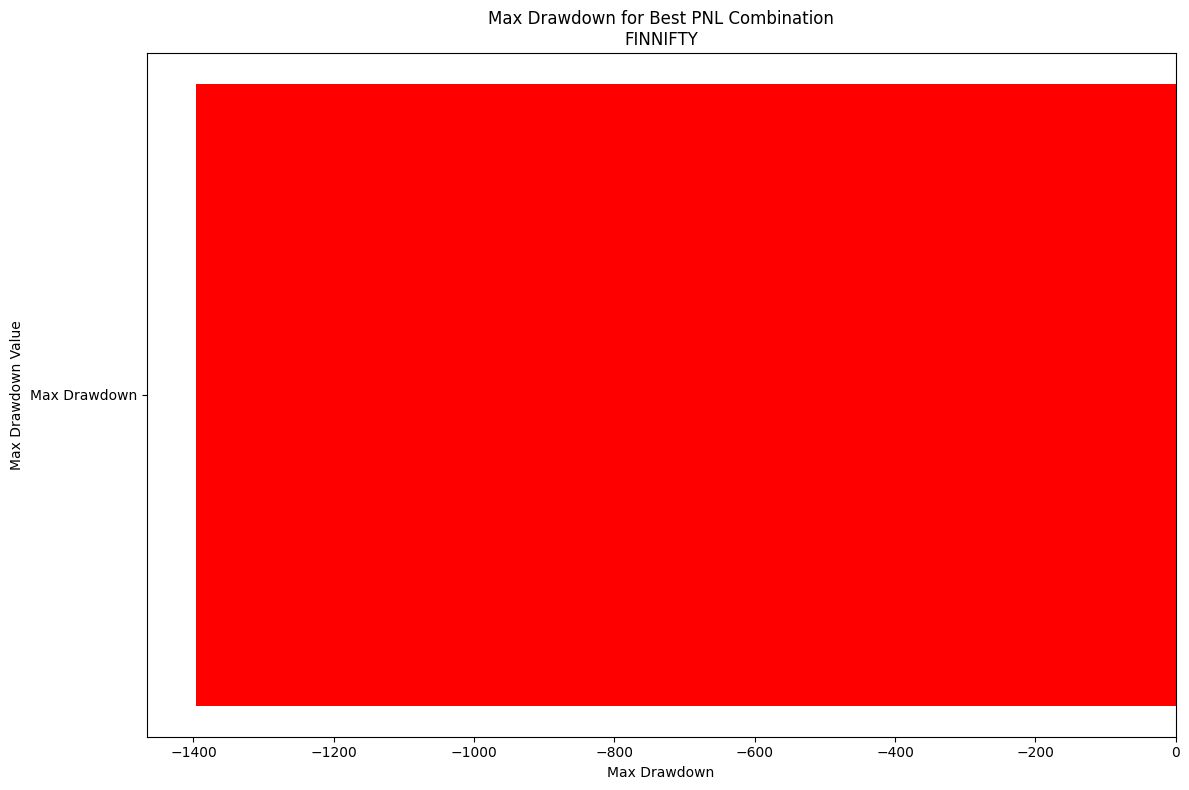

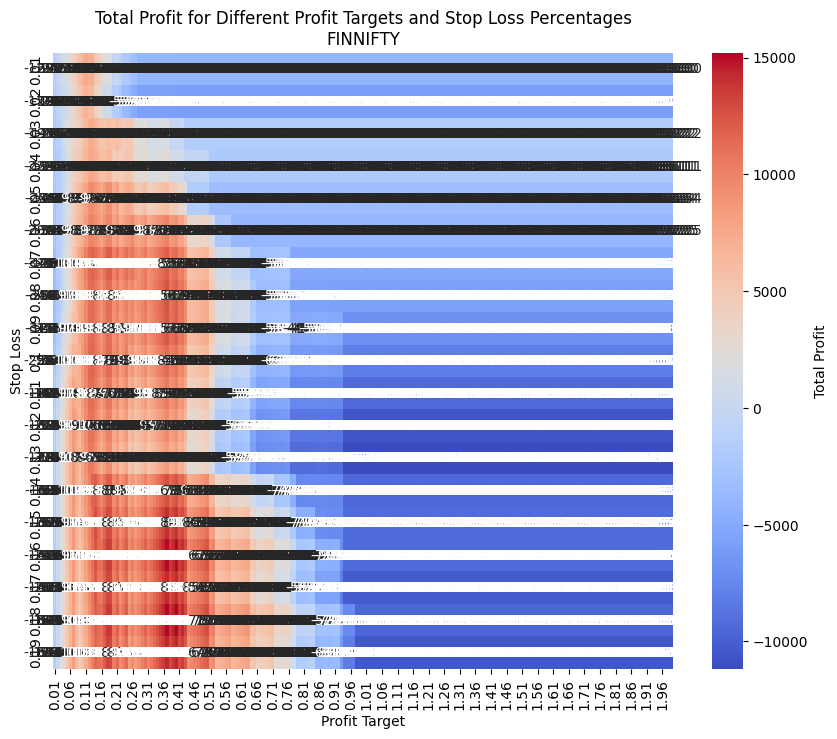

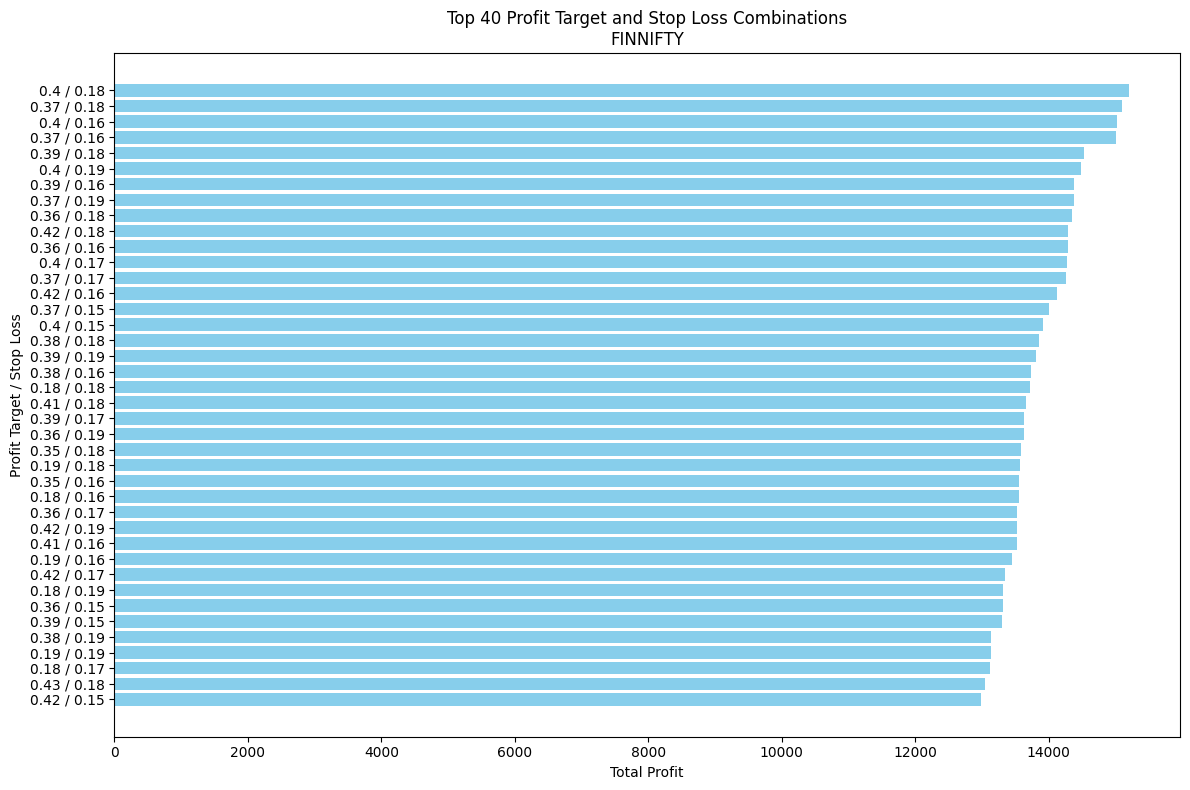

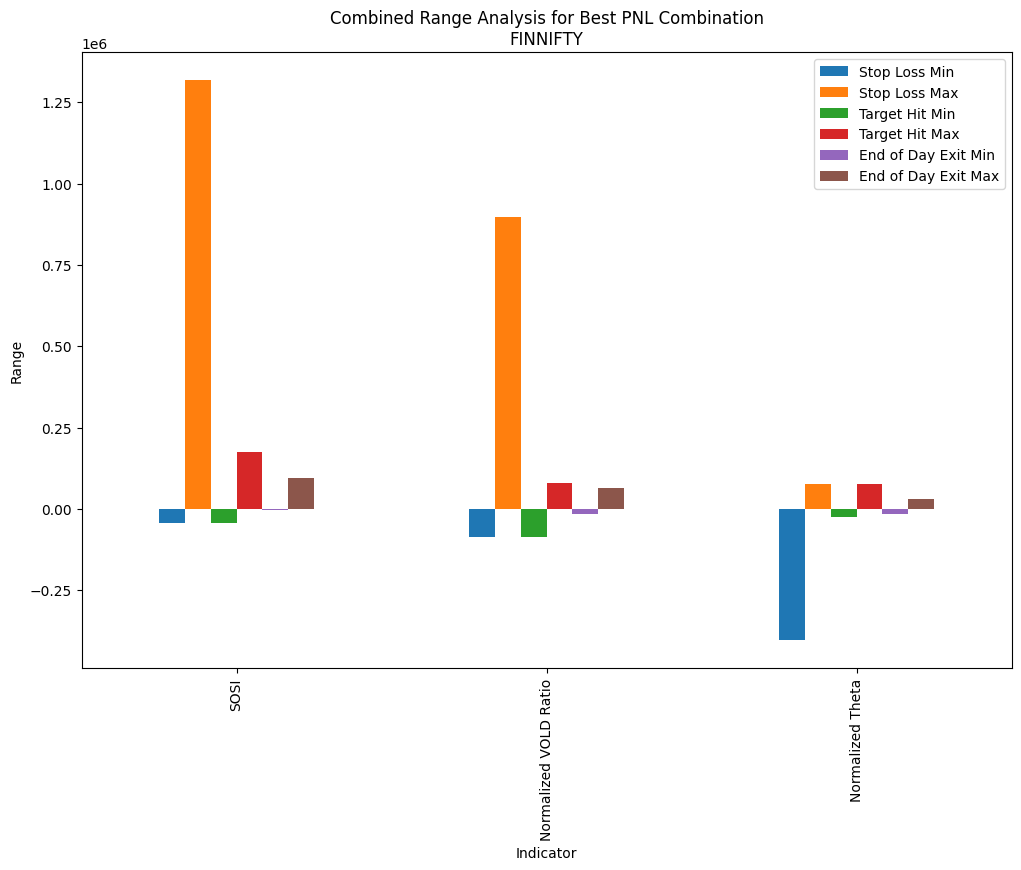

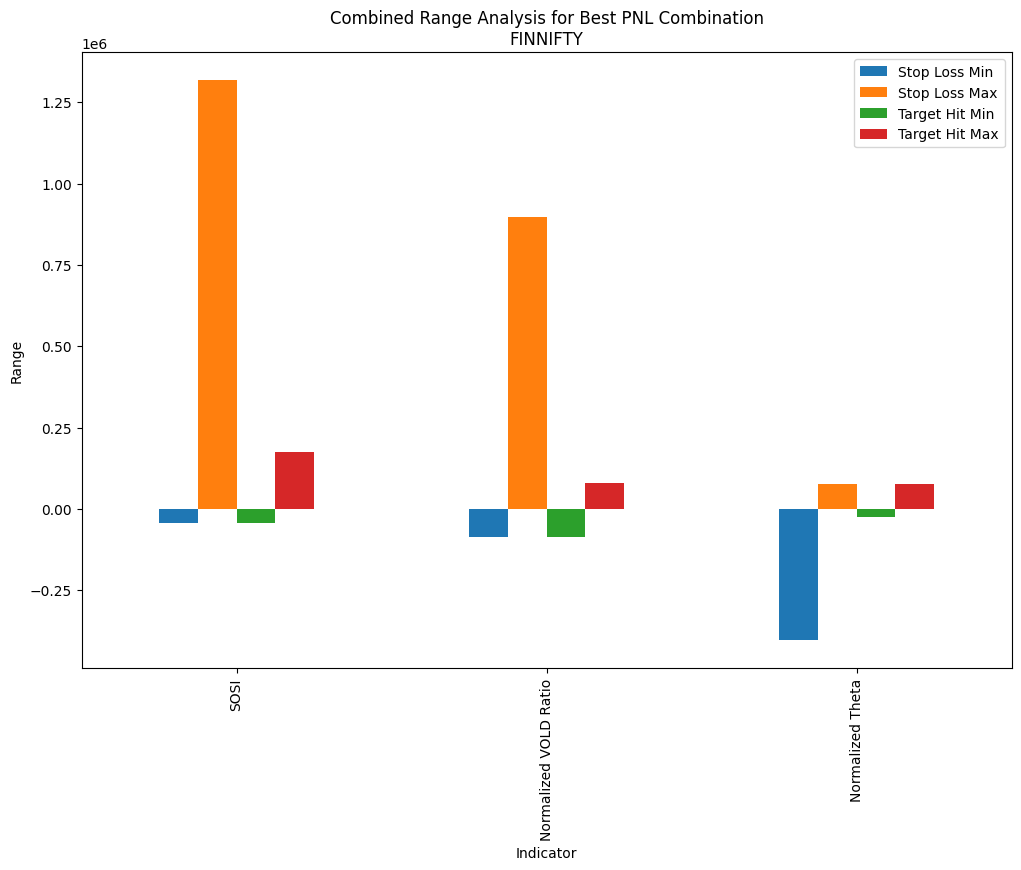

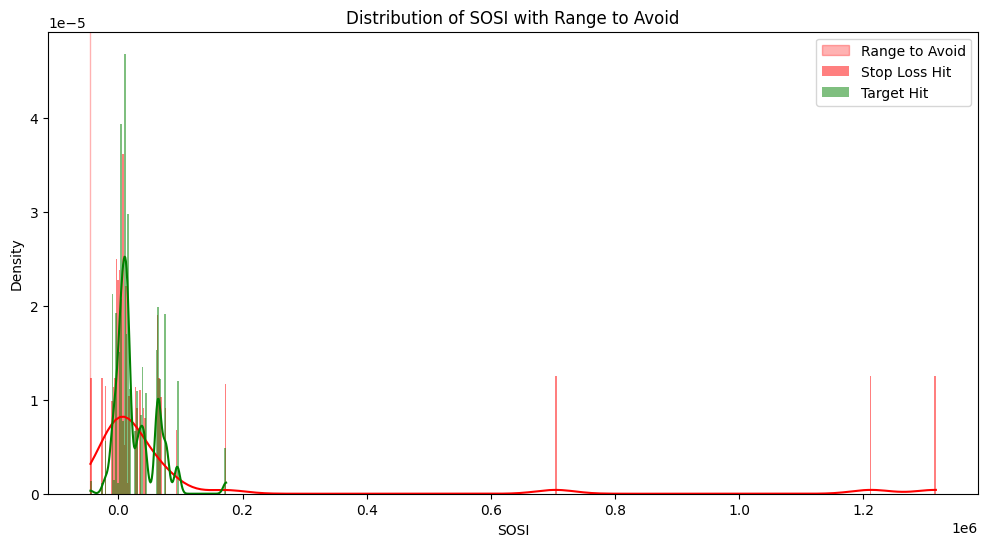

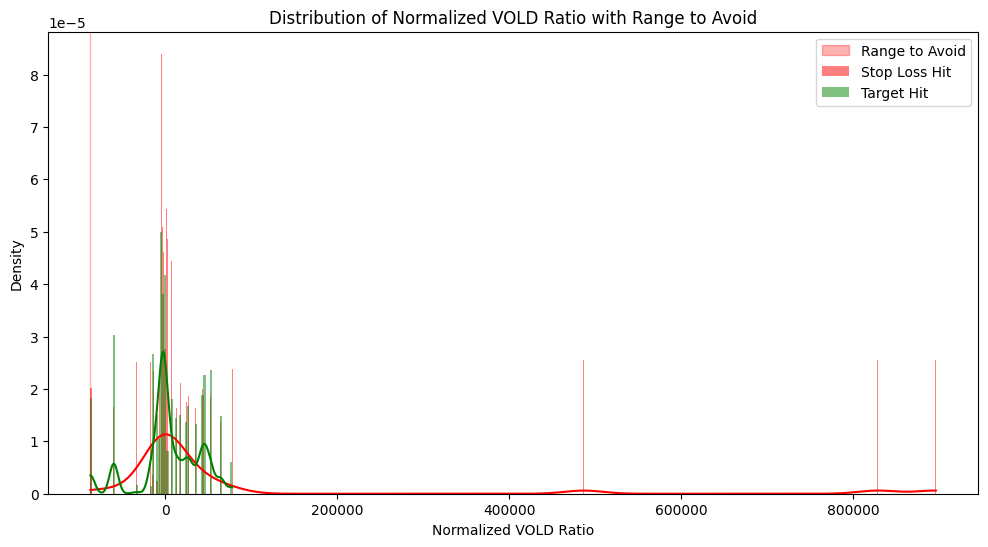

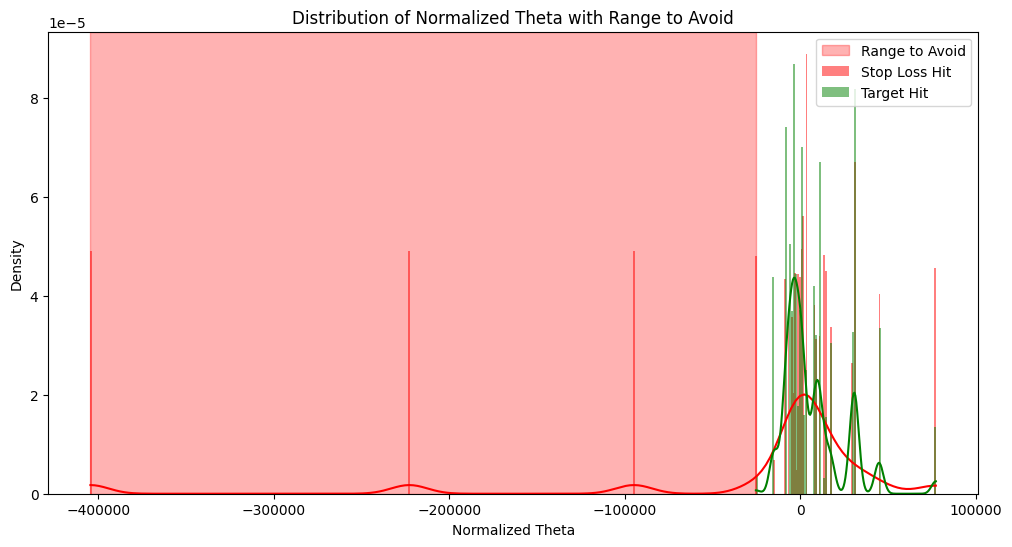

Re-processing NSE_FINNIFTY240625C22500, 1.csv in FINNIFTY...
No buy signals found for NSE_FINNIFTY240625C22500, 1.csv. Skipping...
Re-processing NSE_FINNIFTY240625C22800, 1.csv in FINNIFTY...
No buy signals found for NSE_FINNIFTY240625C22800, 1.csv. Skipping...
Re-processing NSE_FINNIFTY240625C22900, 1.csv in FINNIFTY...
No buy signals found for NSE_FINNIFTY240625C22900, 1.csv. Skipping...
Re-processing NSE_FINNIFTY240625C23000, 1.csv in FINNIFTY...
No buy signals found for NSE_FINNIFTY240625C23000, 1.csv. Skipping...
Re-processing NSE_FINNIFTY240625C23100, 1.csv in FINNIFTY...
No buy signals found for NSE_FINNIFTY240625C23100, 1.csv. Skipping...
Re-processing NSE_FINNIFTY240625C23500, 1.csv in FINNIFTY...
Error: 'volume' column not found in the data.
No buy signals found for NSE_FINNIFTY240625C23500, 1.csv. Skipping...
Re-processing NSE_FINNIFTY240625P22800, 1.csv in FINNIFTY...
No buy signals found for NSE_FINNIFTY240625P22800, 1.csv. Skipping...
Re-processing NSE_FINNIFTY240625P2290

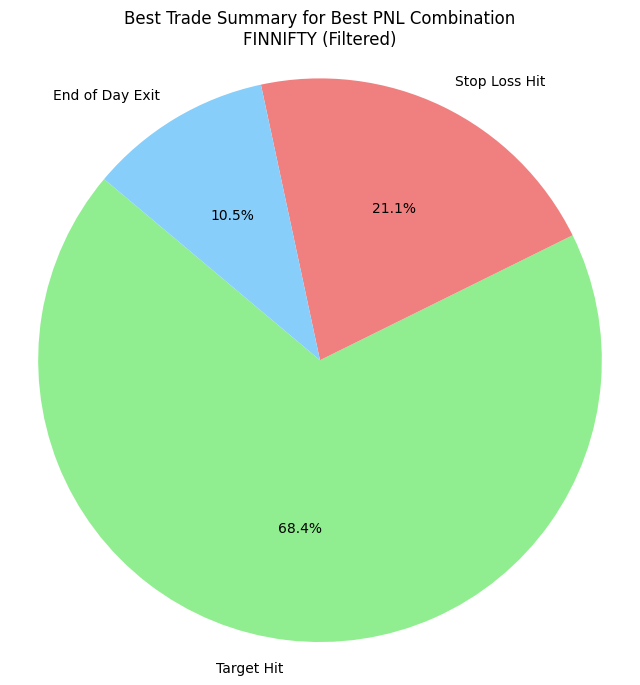

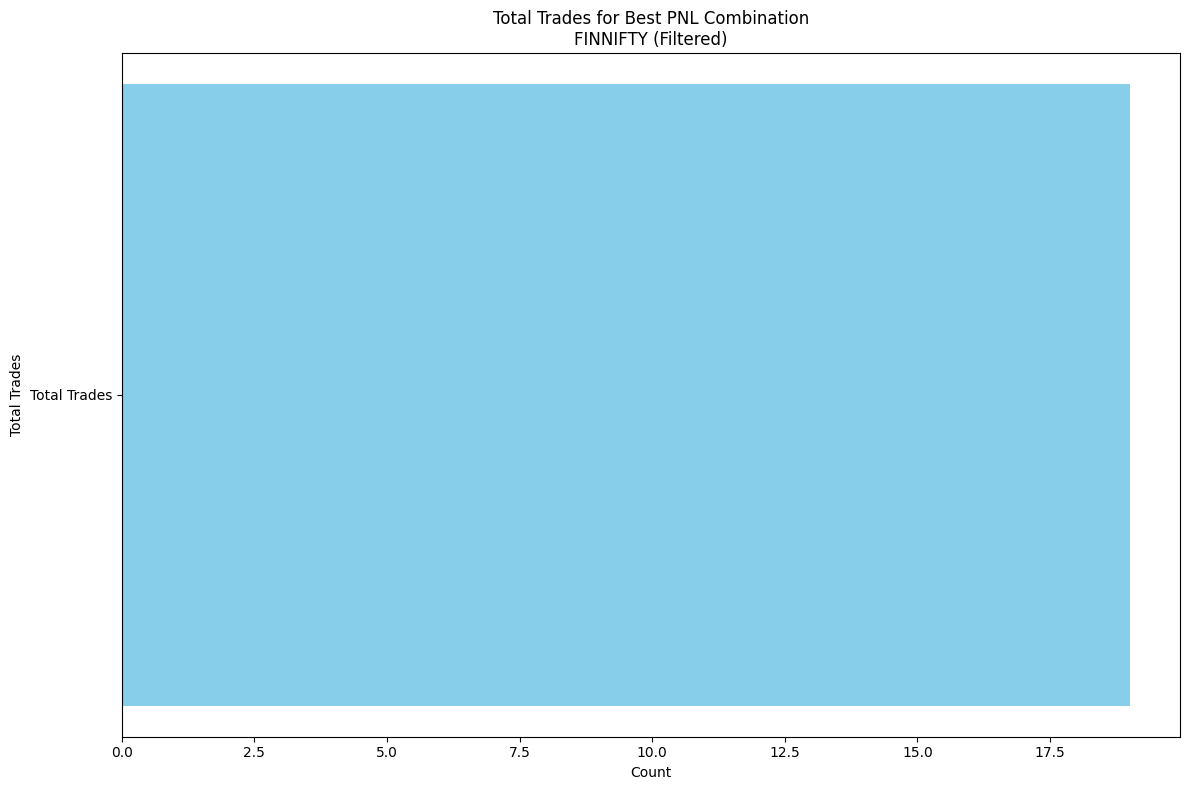

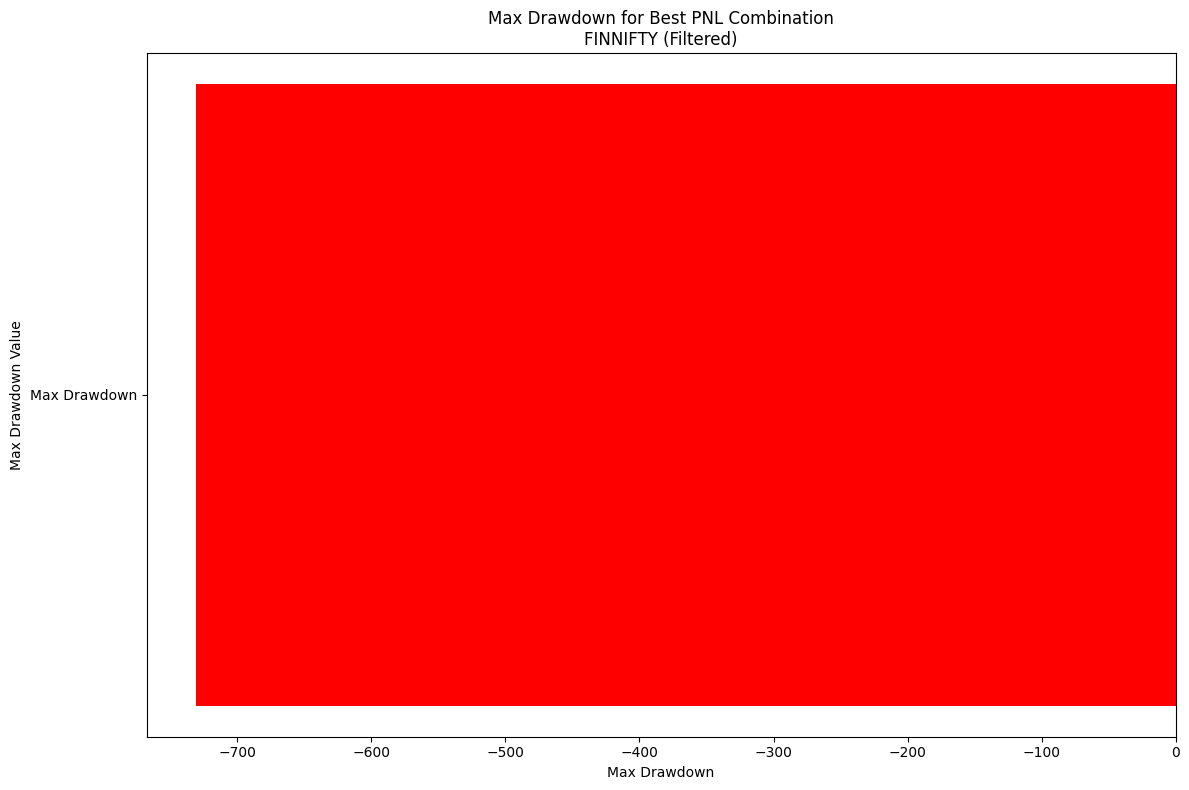

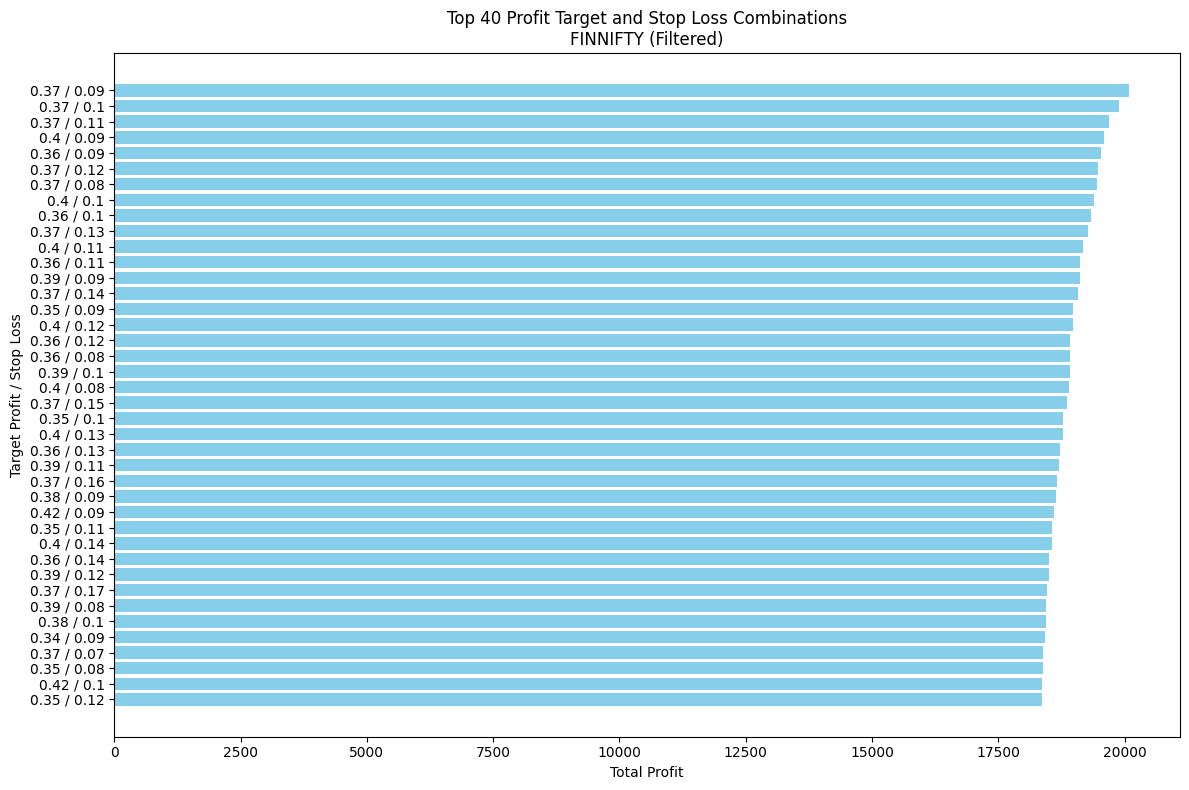

Analysis complete.


In [1]:
from datetime import timedelta
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



# Function to filter buy signals from the 1-minute chart data
def filter_signals(data):
    if 'Buy Signal SOSI Final' not in data.columns:
        print("Warning: 'Buy Signal SOSI Final' column not found in the data.")
        if 'volume' and 'Volume' not in data.columns:
            print("Error: 'volume' column not found in the data.")
            return pd.DataFrame()
        data=calculate_indicators(data)
        if 'Buy Signal SOSI Final' not in data.columns:
            print("Error: 'Buy Signal SOSI Final' column still not found in the data.")
            return pd.DataFrame()
        buy_signals = data[(data['Buy Signal SOSI Final'] == True)]
        return buy_signals
        

    buy_signals = data[(data['Buy Signal SOSI Final'] == True)]
    return buy_signals


# Function to calculate indicators and buy signals
def calculate_indicators(data):
   
    # Calculate VWPCI
    if 'volume' in data.columns:
        volume = data['volume']
    elif 'Volume' in data.columns:
        volume = data['Volume']
    data['priceChangeRatio'] = (data['close'] - data['open']) / (data['high'] - data['low'])
    data['VWPCI'] = data['priceChangeRatio'] * volume


    # Convert Unix timestamp (UTC) to datetime
    data['time_utc'] = pd.to_datetime(data['time'], unit='s', utc=True)

    # Convert UTC to IST
    data['time_ist'] = data['time_utc'] + timedelta(hours=5, minutes=30)

    # Calculate ROC
    roc_periods = 14
    data['ROC'] = data['close'].pct_change(periods=roc_periods)

    # Calculate MVI
    data['MVI'] = volume * ((data['close'] - data['open']) / data['close'])

    # Calculate VOLD
    data['up_volume'] = np.where(data['close'] > data['close'].shift(1), volume, 0)
    data['down_volume'] = np.where(data['close'] <= data['close'].shift(1), volume, 0)
    data['total_up_volume'] = data['up_volume'].cumsum()
    data['total_down_volume'] = data['down_volume'].cumsum()
    data['VOLD_ratio'] = data['total_up_volume'] / data['total_down_volume']

    # Normalize VOLD
    data['normalized_vold'] = (data['VOLD_ratio'] - data['VOLD_ratio'].rolling(window=100).min()) / \
                              (data['VOLD_ratio'].rolling(window=100).max() - data['VOLD_ratio'].rolling(window=100).min())

    # Theta Calculation
    days_to_expiration = 30  # assuming a constant value
    d1 = (np.log(data['close'] / data['close']) + (0.05 + (0.2 * 0.2) / 2) * days_to_expiration / 365) / (0.2 * np.sqrt(days_to_expiration / 365))
    d2 = d1 - 0.2 * np.sqrt(days_to_expiration / 365)
    theta_call = -(data['close'] * 0.2 * np.exp(-0.05 * days_to_expiration / 365) * (np.exp(-(d1 ** 2) / 2) / np.sqrt(2 * np.pi))) / \
                 (2 * np.sqrt(days_to_expiration / 365)) - 0.05 * 100 * np.exp(-0.05 * days_to_expiration / 365) * \
                 (np.exp(-(d2 ** 2) / 2) / np.sqrt(2 * np.pi))
    data['theta'] = theta_call

    # Normalize Theta
    data['normalized_theta'] = (data['theta'] - data['theta'].rolling(window=100).min()) / \
                               (data['theta'].rolling(window=100).max() - data['theta'].rolling(window=100).min())

    # Composite SOSI Calculation
    data['sosi_base'] = 0.1 * data['VWPCI'] + 0.2 * data['ROC'] + 0.3 * data['MVI']
    data['sosi'] = data['sosi_base'] + 0.4 * data['normalized_vold'] + 0.1 * data['normalized_theta']

    # Calculate slopes
    data['sosi_slope'] = data['sosi'] - data['sosi'].shift(1)
    data['vold_slope'] = data['normalized_vold'] - data['normalized_vold'].shift(1)

    # Define conditions
    data['condition1'] = (data['sosi'] < 0) & (data['sosi_slope'] > 0) & (data['normalized_vold'] < 0) & (data['vold_slope'] > 0) & (data['sosi'] < data['normalized_vold'])
    data['condition2'] = (data['sosi'] > 0) & (data['sosi_slope'] > 0) & (data['normalized_vold'] > 0) & (data['vold_slope'] > 0) & (data['sosi'] > data['normalized_vold'])
    data['condition3'] = (data['sosi'] < 0) & (data['sosi_slope'] > 0) & (data['sosi'].shift(1) < data['sosi'].shift(2)) & (data['normalized_vold'] < 0) & (data['vold_slope'] > 0) & (data['normalized_vold'].shift(1) < data['normalized_vold'].shift(2))
    data['condition4'] = (data['sosi_slope'] > 0) & (data['vold_slope'] > 0) & (data['sosi'] < data['normalized_vold'])

    # Combine conditions into the buy signal
    data['Buy Signal SOSI Final'] = (data['time_ist'].dt.time == pd.Timestamp('09:20:00').time()) & (data['condition1'] | data['condition2'] | data['condition3'] | data['condition4'])

    return data


# Function to calculate charges
def calculate_charges(entry_price, exit_price, quantity):
    brokerage = 40  # total brokerage for one complete buy and sell
    stt_ctt = 0.00125 * exit_price * quantity
    transaction_charges = 0.000495 * (entry_price + exit_price) * quantity
    gst = 0.18 * (brokerage + transaction_charges)
    sebi_charges = 10 / 10**7 * (entry_price + exit_price) * quantity
    stamp_charges = 0.00003 * entry_price * quantity
    total_charges = brokerage + stt_ctt + transaction_charges + gst + sebi_charges + stamp_charges
    return total_charges

# Function to simulate day trades with error margin
def simulate_day_trades(buy_signals, minute_data, symbol, profit_target=0.02, stop_loss=0.01, min_stop_loss=0.005, error_margin=0.03):
    results = []

    for index, buy_signal in buy_signals.iterrows():
        entry_price = buy_signal['close'] * (1 + error_margin)  # Adjust entry price with error margin
        entry_time = buy_signal['time'] + 60  # Add 1 minute to the buy signal time to get the entry time

        # Convert entry_time from epoch to datetime
        entry_datetime = pd.to_datetime(entry_time, unit='s')
        entry_datetime_ist = entry_datetime + timedelta(hours=5, minutes=30)  # Convert to IST
        
        # Check if the entry time is post 2:30 PM IST
        if entry_datetime_ist.time() >= datetime.strptime('14:30:00', '%H:%M:%S').time():
            continue  # Skip trades initiated after 2:30 PM IST

        profit_price = entry_price * (1 + profit_target)
        stop_price = entry_price * (1 - max(stop_loss, min_stop_loss))  # Ensure stop loss is at least min_stop_loss
        
        trade_result = {
            'signal_time': buy_signal['time'],
            'entry_time': entry_time,
            'entry_price': entry_price,
            'Target Profit': profit_target,
            'Stop Loss': stop_loss,
            'Profit Price': profit_price,
            'Stop Price': stop_price,
            'exit_time': None,
            'exit_price': None,
            'charges': None,
            'profit_before_charges': None,
            'profit': None,
            'exit_reason': None,
            'SOSI': buy_signal.get('SOSI'),
            'Normalized VOLD Ratio': buy_signal.get('Normalized VOLD Ratio'),
            'Normalized Theta': buy_signal.get('Normalized Theta')
        }
        
        # Filter subsequent data for the same day only
        trade_date = pd.to_datetime(entry_time, unit='s').date()
        subsequent_data = minute_data[(minute_data['time'] > entry_time) & 
                                      (pd.to_datetime(minute_data['time'], unit='s').dt.date == trade_date)]
        
        for _, row in subsequent_data.iterrows():
            if row['high'] >= profit_price:
                trade_result['exit_time'] = row['time']
                trade_result['exit_price'] = profit_price
                trade_result['exit_reason'] = 'Target Hit'
                break
            if row['low'] <= stop_price:
                trade_result['exit_time'] = row['time']
                trade_result['exit_price'] = stop_price
                trade_result['exit_reason'] = 'Stop Loss Hit'
                break
        else:
            # If no target or stop loss hit, exit at the last price of the day
            trade_result['exit_reason'] = 'End of Day Exit'
            if not subsequent_data.empty:
                last_row = subsequent_data.iloc[-1]
                trade_result['exit_time'] = last_row['time']
                trade_result['exit_price'] = last_row['close']
        
        if trade_result['exit_price'] is not None:
            quantity = 25 if 'NIFTY' in symbol else 15 if 'BANKNIFTY' in symbol else 40 if 'FINNIFTY' in symbol else 10
            gross_profit = (trade_result['exit_price'] - trade_result['entry_price']) * quantity
            charges = calculate_charges(trade_result['entry_price'], trade_result['exit_price'], quantity)
            net_profit = gross_profit - charges
            trade_result['charges'] = charges
            trade_result['profit_before_charges'] = gross_profit
            trade_result['profit'] = net_profit

        results.append(trade_result)
    
    results_df = pd.DataFrame(results)

    if results_df.empty:
        return pd.DataFrame(columns=['signal_time', 'entry_time', 'entry_price', 'Target Profit', 'Stop Loss', 
                                     'Profit Price', 'Stop Price', 'exit_time', 'exit_price', 'charges', 
                                     'profit_before_charges', 'profit', 'exit_reason', 'SOSI', 
                                     'Normalized VOLD Ratio', 'Normalized Theta'])
    
    return results_df.dropna(subset=['entry_price'])

# Function to analyze profit and stop loss percentages
def analyze_profit_and_stop_loss(buy_signals, minute_data, profit_percentages, stop_loss_percentages, min_stop_loss=0.005, error_margin=0.01):
    analysis_results = []
    finalresults = []
    for profit_target in profit_percentages:
        for stop_loss in stop_loss_percentages:
            trade_results = simulate_day_trades(buy_signals, minute_data, folder_name, profit_target, stop_loss, min_stop_loss, error_margin)
            total_profit = trade_results['profit'].sum()
            charges = trade_results['charges'].sum()
            profit_before_charges = trade_results['profit_before_charges'].sum()
            analysis_results.append((profit_target, stop_loss, charges, profit_before_charges, total_profit))
            finalresults.append(trade_results)
    # Combine all trade results into a single DataFrame
    combined_trade_results = pd.concat(finalresults, ignore_index=True)
 
    return pd.DataFrame(analysis_results, columns=['Profit Target', 'Stop Loss', 'Charges', 'Profit Before Charges', 'Total Profit']), combined_trade_results

# Function to summarize trade results
def summarize_trade_results(trade_results):
    total_trades = len(trade_results)
    target_hit = len(trade_results[trade_results['exit_reason'] == 'Target Hit'])
    stop_loss_hit = len(trade_results[trade_results['exit_reason'] == 'Stop Loss Hit'])
    end_of_day_exit = len(trade_results[trade_results['exit_reason'] == 'End of Day Exit'])
    max_drawdown = trade_results['profit'].min()
    summary = {
        'Total Trades': total_trades,
        'Target Hit': target_hit,
        'Stop Loss Hit': stop_loss_hit,
        'End of Day Exit': end_of_day_exit,
        'Max Drawdown': max_drawdown
    }
    return summary

# Define profit percentages and stop loss percentages to analyze
profit_percentages = [i / 100 for i in range(1, 200)]
stop_loss_percentages = [i / 100 for i in range(1, 20)]

# Directories containing the data
directories = ['June 2024/NIFTY', 'June 2024/BANKNIFTY', 'June 2024/FINNIFTY']  # Change the directories as needed

# Function to check if the date is within the week of expiration
def is_within_expiry_week(expiry_date, timestamp, folder_name, days_before_expiry=5):
    # Assuming the date is the 7th to 12th characters in the string
    if folder_name == 'NIFTY':
        date_part = expiry_date[9:15]
    if folder_name == 'BANKNIFTY':
        date_part = expiry_date[13:19]
    if folder_name == 'FINNIFTY':
        date_part = expiry_date[12:18]
    if folder_name == 'SENSEX':
        date_part = expiry_date[7:13]
    
    expiry_datetime = pd.to_datetime(date_part, format='%y%m%d')
    signal_datetime = pd.to_datetime(timestamp, unit='s')
    return (expiry_datetime - signal_datetime).days <= days_before_expiry

# Process each directory
for directory in directories:
    pnl_results = []
    trade_results_combined = []
    all_combined_results = []
    folder_name = os.path.basename(directory)
    for subdir, _, files in os.walk(directory):
        if subdir == directory:
            continue  # Skip the top-level directory itself
        for filename in files:
            if ', 1.csv' in filename:  # Change to ', 1.csv' for 1-minute data
                minute_1_path = os.path.join(subdir, filename)
                
                if os.path.exists(minute_1_path):
                    print(f"Processing {filename} in {folder_name}...")
                    
                    # Extract expiry date from filename
                    expiry_date = filename.split(' ')[0].split(',')[0]
                    
                    # Load the CSV file
                    minute_data_1 = pd.read_csv(minute_1_path)
                    
                    # Filter buy signals
                    buy_signals = filter_signals(minute_data_1)

                    # Skip if no buy signals
                    if buy_signals.empty:
                        print(f"No buy signals found for {filename}. Skipping...")
                        continue
                    # Filter signals to only include those within the expiry week
                    buy_signals = buy_signals[buy_signals['time'].apply(lambda x: is_within_expiry_week(expiry_date, x, folder_name))]
                    
                    # Skip if no buy signals within expiry week
                    if buy_signals.empty:
                        print(f"No buy signals found within expiry week for {filename}. Skipping...")
                        continue
                    
                    # Perform the analysis
                    analysis_results, trade_results = analyze_profit_and_stop_loss(buy_signals, minute_data_1, profit_percentages, stop_loss_percentages)
                    
                    # Merge buy signals with trade results
                    combined_results = pd.merge(buy_signals, trade_results, left_on='time', right_on='signal_time', how='inner')
                    
                    # Merge the 1-minute chart data with combined results
                    combined_results = pd.merge(combined_results, minute_data_1, left_on='time', right_on='time', suffixes=('_buy', '_original'))
                   
                    all_combined_results.append(combined_results)
                    
                    # Append to combined results
                    pnl_results.append(analysis_results)
                    trade_results_combined.append(trade_results)
    
    # Combine all results for the folder
    if not pnl_results:
        print(f"No data found for {folder_name}. Skipping...")
        continue    
    combined_pnl_results = pd.concat(pnl_results, ignore_index=True)
    # Aggregate total profits for the same combinations
    combined_pnl_results = combined_pnl_results.groupby(['Profit Target', 'Stop Loss'], as_index=False)['Total Profit'].sum()
    combined_trade_results = pd.concat(trade_results_combined, ignore_index=True)
    combined_all_results = pd.concat(all_combined_results, ignore_index=True)
    
    # Save the results to CSV files
    output_dir = f'Outputs/DayTrade/SOSI/1min/{folder_name}'
    os.makedirs(output_dir, exist_ok=True)
    
    combined_pnl_results.to_csv(f'{output_dir}/{folder_name}_pnl_analysis.csv', index=False)
    combined_trade_results.to_csv(f'{output_dir}/{folder_name}_trade_results.csv', index=False)
    combined_all_results.to_csv(f'{output_dir}/{folder_name}_all_combined_results.csv', index=False)
    
    # Find the best combination of profit target and stop loss
    if not combined_pnl_results.empty:
        best_combination = combined_pnl_results.loc[combined_pnl_results['Total Profit'].idxmax()]
        
        # Save the best combination
        best_combination_df = pd.DataFrame([best_combination])
        best_combination_df.to_csv(f'{output_dir}/{folder_name}_best_combination.csv', index=False)
        
        # Save the top 40 combinations
        top_40_combinations = combined_pnl_results.sort_values(by='Total Profit', ascending=False).head(40)
        top_40_combinations.to_csv(f'{output_dir}/{folder_name}_top_40_combinations.csv', index=False)
        
        # Filter the best trade results from the combined trade results
        best_trade_results = combined_trade_results[(combined_trade_results['Target Profit'] == best_combination['Profit Target']) & 
                                                    (combined_trade_results['Stop Loss'] == best_combination['Stop Loss'])]
        
        # Summarize the trade results for the best combination
        trade_summary = summarize_trade_results(best_trade_results)
        
        # Save the trade summary
        trade_summary_df = pd.DataFrame([trade_summary])
        trade_summary_df.to_csv(f'{output_dir}/{folder_name}_trade_summary.csv', index=False)
        
        # Plot the pie chart for trade summary
        labels = ['Target Hit', 'Stop Loss Hit', 'End of Day Exit']
        sizes = [trade_summary['Target Hit'], trade_summary['Stop Loss Hit'], trade_summary['End of Day Exit']]
        colors = ['lightgreen', 'lightcoral', 'lightskyblue']
        plt.figure(figsize=(8, 8))
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        plt.title(f'Trade Summary for Best PNL Combination\n{folder_name}')
        plt.axis('equal')
        plt.show()
        plt.savefig(f'{output_dir}/{folder_name}_trade_summary_pie_chart.png')
        plt.close()
        
        # Plot the bar chart for total trades
        plt.figure(figsize=(12, 8))
        plt.barh(['Total Trades'], [trade_summary['Total Trades']], color='skyblue')
        plt.xlabel('Count')
        plt.ylabel('Total Trades')
        plt.title(f'Total Trades for Best PNL Combination\n{folder_name}')
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{output_dir}/{folder_name}_total_trades_bar_chart.png')
        plt.close()

        # Plot the bar chart for max drawdown
        plt.figure(figsize=(12, 8))
        plt.barh(['Max Drawdown'], [trade_summary['Max Drawdown']], color='red')
        plt.xlabel('Max Drawdown')
        plt.ylabel('Max Drawdown Value')
        plt.title(f'Max Drawdown for Best PNL Combination\n{folder_name}')
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{output_dir}/{folder_name}_max_drawdown_bar_chart.png')
        plt.close()

        # Plot the heatmap for better visualization
        pivot_table = combined_pnl_results.pivot(index="Stop Loss", columns="Profit Target", values="Total Profit")
        plt.figure(figsize=(10, 8))
        sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Total Profit'})
        plt.title(f"Total Profit for Different Profit Targets and Stop Loss Percentages\n{folder_name}")
        plt.xlabel("Profit Target")
        plt.ylabel("Stop Loss")
        plt.show()
        plt.savefig(f'{output_dir}/{folder_name}_heatmap.png')
        plt.close()

        # Plot the bar chart for the top 40 combinations
        plt.figure(figsize=(12, 8))
        plt.barh(top_40_combinations['Profit Target'].astype(str) + " / " + top_40_combinations['Stop Loss'].astype(str),
                 top_40_combinations['Total Profit'], color='skyblue')
        plt.xlabel('Total Profit')
        plt.ylabel('Profit Target / Stop Loss')
        plt.title(f'Top 40 Profit Target and Stop Loss Combinations\n{folder_name}')
        plt.gca().invert_yaxis()  # To display the highest
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{output_dir}/{folder_name}_top_40_combinations.png')
        plt.close()

                # Ensure all indicators are included in the calculations, even if some have no data
        def combined_range_analysis():
            indicators = ['SOSI', 'Normalized VOLD Ratio', 'Normalized Theta']
            stop_loss_hits = combined_trade_results[combined_trade_results['exit_reason'] == 'Stop Loss Hit']
            target_hits = combined_trade_results[combined_trade_results['exit_reason'] == 'Target Hit']
            end_of_day_exits = combined_trade_results[combined_trade_results['exit_reason'] == 'End of Day Exit']
        
            if stop_loss_hits.empty and target_hits.empty and end_of_day_exits.empty:
                print("No data available for combined range analysis.")
                return
        
            def get_min_max(data, indicator):
                if indicator in data.columns:
                    return data[indicator].min(), data[indicator].max()
                else:
                    return float('nan'), float('nan')
        
            stop_loss_ranges = pd.Series({indicator: get_min_max(stop_loss_hits, indicator) for indicator in indicators})
            target_hit_ranges = pd.Series({indicator: get_min_max(target_hits, indicator) for indicator in indicators})
            end_of_day_exit_ranges = pd.Series({indicator: get_min_max(end_of_day_exits, indicator) for indicator in indicators})
        
            combined_data = {
                'Indicator': indicators,
                'Stop Loss Min': [rng[0] for rng in stop_loss_ranges],
                'Stop Loss Max': [rng[1] for rng in stop_loss_ranges],
                'Target Hit Min': [rng[0] for rng in target_hit_ranges],
                'Target Hit Max': [rng[1] for rng in target_hit_ranges],
                'End of Day Exit Min': [rng[0] for rng in end_of_day_exit_ranges],
                'End of Day Exit Max': [rng[1] for rng in end_of_day_exit_ranges]
            }
        
            combined_data_df = pd.DataFrame(combined_data)
        
            # Convert all relevant columns to numeric
            for col in ['Stop Loss Min', 'Stop Loss Max', 'Target Hit Min', 'Target Hit Max', 'End of Day Exit Min', 'End of Day Exit Max']:
                combined_data_df[col] = pd.to_numeric(combined_data_df[col], errors='coerce')
        
            # Ensure there is numeric data to plot
            numeric_data = combined_data_df.drop(columns=['Indicator']).dropna(how='all', axis=1)
        
            if not numeric_data.empty and not combined_data_df.empty:
                combined_data_df.set_index('Indicator').plot(kind='bar', figsize=(12, 8))
                plt.title(f'Combined Range Analysis for Best PNL Combination\n{folder_name}')
                plt.ylabel('Range')
                plt.show()
                plt.savefig(f'{output_dir}/{folder_name}_combined_range_analysis.png')
                plt.close()
            else:
                print("No numeric data available for combined range analysis.")
        

        # Call the function to perform the combined range analysis
        combined_range_analysis()

        def identify_ranges_to_avoid():
            indicators = ['SOSI', 'Normalized VOLD Ratio', 'Normalized Theta']
            stop_loss_hits = combined_trade_results[combined_trade_results['exit_reason'] == 'Stop Loss Hit']
            target_hits = combined_trade_results[combined_trade_results['exit_reason'] == 'Target Hit']
        
            def get_min_max(data, indicator):
                if indicator in data.columns:
                    return data[indicator].min(), data[indicator].max()
                else:
                    return float('nan'), float('nan')
        
            stop_loss_ranges = {indicator: get_min_max(stop_loss_hits, indicator) for indicator in indicators}
            target_hit_ranges = {indicator: get_min_max(target_hits, indicator) for indicator in indicators}
            
            combined_data = {
                'Indicator': indicators,
                'Stop Loss Min': [stop_loss_ranges[ind][0] for ind in indicators],
                'Stop Loss Max': [stop_loss_ranges[ind][1] for ind in indicators],
                'Target Hit Min': [target_hit_ranges[ind][0] for ind in indicators],
                'Target Hit Max': [target_hit_ranges[ind][1] for ind in indicators],
            }
        
            combined_data_df = pd.DataFrame(combined_data)
        
            # Convert all relevant columns to numeric
            for col in ['Stop Loss Min', 'Stop Loss Max', 'Target Hit Min', 'Target Hit Max']:
                combined_data_df[col] = pd.to_numeric(combined_data_df[col], errors='coerce')
        
            # Ensure there is numeric data to plot
            numeric_data = combined_data_df.drop(columns=['Indicator']).dropna(how='all', axis=1)
        
            if not numeric_data.empty:
                combined_data_df.set_index('Indicator').plot(kind='bar', figsize=(12, 8))
                plt.title(f'Combined Range Analysis for Best PNL Combination\n{folder_name}')
                plt.ylabel('Range')
                plt.show()
                plt.savefig(f'{output_dir}/{folder_name}_combined_range_analysis.png')
                plt.close()
            else:
                print("No numeric data available for combined range analysis.")
        
            # Print the ranges to avoid
            ranges_to_avoid = {}
            for indicator in indicators:
                stop_loss_min, stop_loss_max = combined_data_df.loc[combined_data_df['Indicator'] == indicator, ['Stop Loss Min', 'Stop Loss Max']].values[0]
                target_hit_min, target_hit_max = combined_data_df.loc[combined_data_df['Indicator'] == indicator, ['Target Hit Min', 'Target Hit Max']].values[0]
                
                if pd.notna(stop_loss_min) and pd.notna(stop_loss_max):
                    if pd.notna(target_hit_min) and pd.notna(target_hit_max):
                        if stop_loss_min <= target_hit_min <= stop_loss_max:
                            stop_loss_max = target_hit_min - 1e-9
                        if stop_loss_min <= target_hit_max <= stop_loss_max:
                            stop_loss_min = target_hit_max + 1e-9
                    
                    ranges_to_avoid[indicator] = (stop_loss_min, stop_loss_max)
        
            # Visualize the ranges to avoid
            for indicator, avoid_range in ranges_to_avoid.items():
                plt.figure(figsize=(12, 6))
                sns.histplot(stop_loss_hits[indicator], color='red', label='Stop Loss Hit', kde=True, stat="density", linewidth=0)
                sns.histplot(target_hits[indicator], color='green', label='Target Hit', kde=True, stat="density", linewidth=0)
                plt.axvspan(*avoid_range, color='red', alpha=0.3, label='Range to Avoid')
                plt.xlabel(indicator)
                plt.ylabel('Density')
                plt.title(f'Distribution of {indicator} with Range to Avoid')
                plt.legend()
                plt.show()
                plt.savefig(f'{output_dir}/{folder_name}_{indicator}_range_to_avoid.png')
                plt.close()
        
            # Save the ranges to avoid in a text file
            with open(f'{output_dir}/{folder_name}_ranges_to_avoid.txt', 'w') as f:
                for indicator, (min_val, max_val) in ranges_to_avoid.items():
                    f.write(f"{indicator}: {min_val} to {max_val}\n")
        
            return ranges_to_avoid
        
        # Call the function to identify ranges to avoid
        ranges_to_avoid = identify_ranges_to_avoid()

        # Filter out trades that fall into the ranges to avoid
        def filter_trades(trades, ranges_to_avoid):
            for indicator, (min_val, max_val) in ranges_to_avoid.items():
                if min_val is not None and max_val is not None:
                    # Create a boolean mask for trades to remove
                    mask = (trades[indicator] >= min_val) & (trades[indicator] <= max_val)
                    trades = trades[~mask]
            return trades

        # Re-run the analysis excluding trades that fall into the ranges to avoid
        new_trade_results_combined = []
        new_all_combined_results = []
        directories = [f'June 2024/{folder_name}']
        for directory in directories:
            folder_name = os.path.basename(directory)
            for subdir, _, files in os.walk(directory):
                if subdir == directory:
                    continue  # Skip the top-level directory itself
                for filename in files:
                    if ', 1.csv' in filename:  # Change to ', 1.csv' for 1-minute data
                        minute_1_path = os.path.join(subdir, filename)
                        
                        if os.path.exists(minute_1_path):
                            print(f"Re-processing {filename} in {folder_name}...")
                            
                            # Load the CSV file
                            minute_data_1 = pd.read_csv(minute_1_path)
                            
                            # Filter buy signals
                            buy_signals = filter_signals(minute_data_1)
                            
                            # Skip if no buy signals
                            if buy_signals.empty:
                                print(f"No buy signals found for {filename}. Skipping...")
                                continue
                            
                            # Filter signals to only include those within the expiry week
                            buy_signals = buy_signals[buy_signals['time'].apply(lambda x: is_within_expiry_week(expiry_date, x, folder_name))]
                            
                            # Skip if no buy signals within expiry week
                            if buy_signals.empty:
                                print(f"No buy signals found within expiry week for {filename}. Skipping...")
                                continue
                            
                            # Perform the analysis
                            analysis_results, trade_results = analyze_profit_and_stop_loss(buy_signals, minute_data_1, profit_percentages, stop_loss_percentages)
                            
                            # Filter out trades that fall into the ranges to avoid
                            trade_results = filter_trades(trade_results, ranges_to_avoid)
                            
                            if not trade_results.empty:
                                # Merge buy signals with trade results
                                combined_results = pd.merge(buy_signals, trade_results, left_on='time', right_on='signal_time', how='inner')
                                
                                # Merge the 1-minute chart data with combined results
                                combined_results = pd.merge(combined_results, minute_data_1, left_on='time', right_on='time', suffixes=('_buy', '_original'))
                               
                                new_all_combined_results.append(combined_results)
                                new_trade_results_combined.append(trade_results)
        
        # Combine all results for the new filtered trades
        if new_trade_results_combined:
            new_combined_trade_results = pd.concat(new_trade_results_combined, ignore_index=True)
            new_combined_all_results = pd.concat(new_all_combined_results, ignore_index=True)
            
            # Save the new filtered trade results to CSV files
            new_output_dir = f'Outputs/DayTrade/SOSI/1min/{folder_name}_filtered'
            os.makedirs(new_output_dir, exist_ok=True)
            
            new_combined_trade_results.to_csv(f'{new_output_dir}/{folder_name}_filtered_trade_results.csv', index=False)
            new_combined_all_results.to_csv(f'{new_output_dir}/{folder_name}_filtered_all_combined_results.csv', index=False)
            
            # Re-calculate top 40 combinations for the filtered trades
            new_combined_pnl_results = new_combined_trade_results.groupby(['Target Profit', 'Stop Loss'], as_index=False)['profit'].sum()
            new_top_40_combinations = new_combined_pnl_results.sort_values(by='profit', ascending=False).head(40)
            new_top_40_combinations.to_csv(f'{new_output_dir}/{folder_name}_filtered_top_40_combinations.csv', index=False)
            
            # Find the best combination of profit target and stop loss after filtering
            best_combination_filtered = new_top_40_combinations.loc[new_top_40_combinations['profit'].idxmax()]
            
            # Filter the best trade results from the combined trade results
            best_trade_results_filtered = new_combined_trade_results[
                (new_combined_trade_results['Target Profit'] == best_combination_filtered['Target Profit']) & 
                (new_combined_trade_results['Stop Loss'] == best_combination_filtered['Stop Loss'])
            ]
            
            # Re-summarize the best trade results after filtering
            best_trade_summary_filtered = summarize_trade_results(best_trade_results_filtered)
            
            # Save the best trade summary after filtering
            best_trade_summary_filtered_df = pd.DataFrame([best_trade_summary_filtered])
            best_trade_summary_filtered_df.to_csv(f'{new_output_dir}/{folder_name}_filtered_best_trade_summary.csv', index=False)
            
            # Plot the new pie chart for best trade summary
            labels = ['Target Hit', 'Stop Loss Hit', 'End of Day Exit']
            sizes = [best_trade_summary_filtered['Target Hit'], best_trade_summary_filtered['Stop Loss Hit'], best_trade_summary_filtered['End of Day Exit']]
            colors = ['lightgreen', 'lightcoral', 'lightskyblue']
            plt.figure(figsize=(8, 8))
            plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
            plt.title(f'Best Trade Summary for Best PNL Combination\n{folder_name} (Filtered)')
            plt.axis('equal')
            plt.show()
            plt.savefig(f'{new_output_dir}/{folder_name}_filtered_best_trade_summary_pie_chart.png')
            plt.close()
            
            # Plot the new bar chart for total trades for best PNL
            plt.figure(figsize=(12, 8))
            plt.barh(['Total Trades'], [best_trade_summary_filtered['Total Trades']], color='skyblue')
            plt.xlabel('Count')
            plt.ylabel('Total Trades')
            plt.title(f'Total Trades for Best PNL Combination\n{folder_name} (Filtered)')
            plt.tight_layout()
            plt.show()
            plt.savefig(f'{new_output_dir}/{folder_name}_filtered_total_trades_bar_chart.png')
            plt.close()
        
            # Plot the new bar chart for max drawdown for best PNL
            plt.figure(figsize=(12, 8))
            plt.barh(['Max Drawdown'], [best_trade_summary_filtered['Max Drawdown']], color='red')
            plt.xlabel('Max Drawdown')
            plt.ylabel('Max Drawdown Value')
            plt.title(f'Max Drawdown for Best PNL Combination\n{folder_name} (Filtered)')
            plt.tight_layout()
            plt.show()
            plt.savefig(f'{new_output_dir}/{folder_name}_filtered_max_drawdown_bar_chart.png')
            plt.close()
        
            # Plot the bar chart for the top 40 combinations
            plt.figure(figsize=(12, 8))
            plt.barh(new_top_40_combinations['Target Profit'].astype(str) + " / " + new_top_40_combinations['Stop Loss'].astype(str),
                     new_top_40_combinations['profit'], color='skyblue')
            plt.xlabel('Total Profit')
            plt.ylabel('Target Profit / Stop Loss')
            plt.title(f'Top 40 Profit Target and Stop Loss Combinations\n{folder_name} (Filtered)')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
            plt.savefig(f'{new_output_dir}/{folder_name}_filtered_top_40_combinations.png')
            plt.close()
        
        else:
            print(f"No trades remaining after filtering for {folder_name}.")
  
print("Analysis complete.")


